# Coupled-channel interpretation of the LHCb double-$J/\psi$ spectrum 

Code for the following paper:

X.-K. Dong, V. Baru, F.-K. Guo, C. Hanhart, A. Nefediev, _Coupled-channel interpretation of the LHCb double-$J/\psi$ spectrum and hints of a new state near $J/\psi J/\psi$threshold_, [[arXiv:2009.07795]](https://arxiv.org/abs/2009.07795): 

![LHCb data and fitting of di-$J/\psi$ candidates](data/LHCbfit.png)

# Code

The fit is performed using [`IMinuit.jl`](https://github.com/fkguo/IMinuit.jl), which is a julia wrapper of `iminuit`, a Python interface to `MINUIT2`.

It can be installed in `REPL` by `]add https://github.com/fkguo/IMinuit.jl`, or in jupyter notebook by

```julia
using Pkg; 
Pkg.add(PackageSpec(url="https://github.com/fkguo/IMinuit.jl"))
```

In [ ]:
# Uncomment this cell for binder
ENV["PYTHON"] = ""
using Pkg
Pkg.build("PyCall")
Pkg.add(PackageSpec(url="https://github.com/zhanglm79/IMinuit.jl"))
Pkg.add(PackageSpec(url="https://github.com/zhanglm79/LoopTools.jl"))

In [1]:
using IMinuit, QuadGK, NLsolve
using CSV, DataFrames, LaTeXStrings; ENV["COLUMNS"]=160
import PyPlot
using Plots; pyplot(frame=:box, minorticks=5, size=(500,350)) 
using BenchmarkTools;
PyPlot.matplotlib.rc("mathtext", fontset="cm")      
PyPlot.matplotlib.rc("font", family="serif", size=11) 

┌ Info: Precompiling IMinuit [beb75e20-2205-47e6-ad51-640e9c2309f1]
└ @ Base loading.jl:1260
┌ Info: Precompiling QuadGK [1fd47b50-473d-5c70-9696-f719f8f3bcdc]
└ @ Base loading.jl:1260
┌ Info: Precompiling NLsolve [2774e3e8-f4cf-5e23-947b-6d7e65073b56]
└ @ Base loading.jl:1260
┌ Info: Precompiling CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
└ @ Base loading.jl:1260
┌ Info: Precompiling LaTeXStrings [b964fa9f-0449-5b57-a5c2-d3ea65f4040f]
└ @ Base loading.jl:1260
┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1260
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1260
┌ Info: Precompiling BenchmarkTools [6e4b80f9-dd63-53aa-95a3-0cdb28fa8baf]
└ @ Base loading.jl:1260


In [2]:
include("quadgauss.jl");
include("hadronmasses.jl");

In [3]:
λ(a,b,c) = a^2+b^2+c^2-2a*b-2b*c-2a*c

function qsq(E,m1,m2) 
    return λ(E^2,m1^2,m2^2)/(4E^2)
end

# 2-body phase space factor
phsp(E,m1,m2) = sqrt(qsq(E,m1,m2))/(8π*E);

## Data from the LHCb paper

In [4]:
# read the data from file and wrap that into Data defined in IMinuit
data_full_df=DataFrame!(CSV.File("data/data_lhcb.csv", header=["w", "y", "err"]))
const data_full=Data(data_full_df);

In [6]:
# DPS curve extracted from the LHCb paper
dps_a_df=DataFrame!(CSV.File("data/DPS_a.csv", header=["w", "dps"]))
const dps_data=Data(dps_a_df.:w ./1000, dps_a_df.:dps, 0.1*ones(size(dps_a_df)[1]));

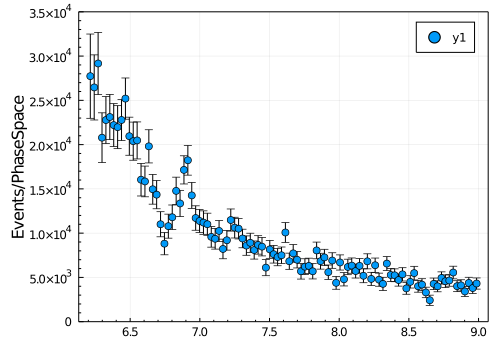

In [7]:
let xv = data_full.x
    @plt_data Data(xv, data_full.y ./ phsp.(xv,mjψ, mjψ), data_full.err ./ phsp.(xv,mjψ, mjψ)) ylim=(0, 3.5e4) ylabel="Events/PhaseSpace"
end

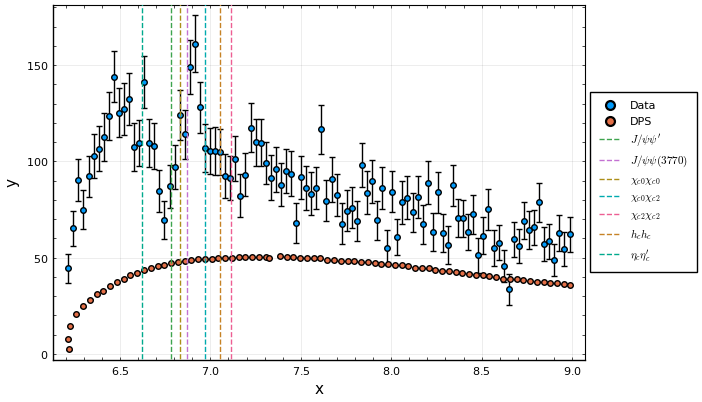

In [13]:
@plt_data data_full
@plt_data! dps_data label="DPS" legend=:outerright size=(700,400)
vline!([mjψ+mψp], line=:dash, label=L"J/\psi\psi'")
vline!([mjψ+mψ3770], line=:dash, label=L"J/\psi\psi(3770)")
vline!([2mχc0], line=:dash, label=L"\chi_{c0}\chi_{c0}")
vline!([mχc0+mχc2], line=:dash, label=L"\chi_{c0}\chi_{c2}")
vline!([2mχc2], line=:dash, label=L"\chi_{c2}\chi_{c2}")
vline!([2mhc], line=:dash, label=L"h_c h_c")
vline!([mηc+mηcp], line=:dash, label=L"\eta_c\eta_c'")

**Many thresholds** in the interesting energy region, but
* $\eta_c\eta_c'$, $h_ch_c$: coupling to $J/\psi J/\psi$ suppressed by HQSS
* $\chi_{cJ}\chi_{cJ'}$: need to exchange $\omega$ for the coupling to $J/\psi J/\psi$; heavier than $\sigma$ ($\pi\pi$), could be relatively suppressed 
* $\mathbf{J/\psi \psi(2S)}$ and $\mathbf{J/\psi \psi(3770)}$ are arguably the most relevant ones

We consider two cases:

* Two channels: $J/\psi J/\psi$ and $J/\psi \psi(2S)$
* Three channels: $J/\psi J/\psi$, $J/\psi \psi(2S)$ and $J/\psi \psi(3770)$

The amplitude for producing double-$J/\psi$:
$$P(E)\left[1 + \sum_i r_i G_i(E) T_{i1}(E) \right]$$

The $T$-matrix is given by
$$T(E) = V(E)\cdot[1-G(E)V(E)]^{-1}$$
where $G(E)$ a diagonal matrix with elements: $$G_i(E)=i\int \frac{d^4q}{(2\pi)^4}\frac1{(q^2-m_1^2+i\epsilon)[(P-q)^2-m_2^2+i\epsilon]}$$
the two-point scalar loop integral.

For the production vertex, we assume an expontial form $$P(E)=\alpha e^{-\beta E^2},$$ which can perfectly describe the double-parton scattering (DPS) distribution.

We assume the matrix for the contact term take the following form:

* For two channels,
\begin{align}
V_{11}=&\, 4m_{J/\psi}^2(a_1+b_1 k_1^2),\ \ V_{12}=V_{21}=4m_{J/\psi}\sqrt{m_{J/\psi}m_{\psi'}}c,\notag\\
V_{22}=&\, 4m_{J/\psi}m_{\psi'}(a_2+b_2 k_2^2),
\end{align}
with five parameters $a_{1,2}, b_{1,2}, c$.

* For three channels, $V$ is taken to be simply a symmetric constant matrix with 6 parameters: $a_{11,12,13,22,23,33}$.

Fit the DPS distribution using $$\rho(E) |P(E)|^2 = \rho(E) \alpha^2 e^{-2\beta E^2}$$ with $\rho(E) = k/(8\pi E)$ the phase space factor.

In [9]:
# parameters are collected into an array or tuple
dpsmodel(x, par) = phsp(x, mjψ, mjψ) * (par[1] * exp(-par[2]*x^2))^2

dpsfit_poly = @model_fit dpsmodel dps_data [1., 0.0] name=[:alpha, :beta]
migrad(dpsfit_poly)

PyObject MigradResult(fmin=FMin(fval=10472.076086881634, edm=1.5928681563043768e-06, tolerance=0.1, nfcn=128, ncalls=128, up=1.0, is_valid=True, has_valid_parameters=True, has_accurate_covar=True, has_posdef_covar=True, has_made_posdef_covar=False, hesse_failed=False, has_covariance=True, is_above_max_edm=False, has_reached_call_limit=False, has_parameters_at_limit=False), params=[Param(number=0, name='alpha', value=133.67014555125894, error=0.09625214082296485, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=1, name='beta', value=0.01233631823566983, error=1.2136511532941773e-05, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None)])

In [13]:
?model_fit

search: model_fit @model_fit



```
model_fit(model::Function, data::Data, start_values; kws...)
```

convenient wrapper for fitting a `model` to `data`; the returning stype is `ArrayFit`, which can be passed to `migrad`, `minos` etc.

  * `model` is the function to be fitted to `data`; it should be of the form `model(x, params)` with `params` given either as an array or a tuple.
  * `start_values` can be either the initial values of parameters (`<: AbstractArray` or `<:Tuple`) or a previous fit of type `AbstractFit`.


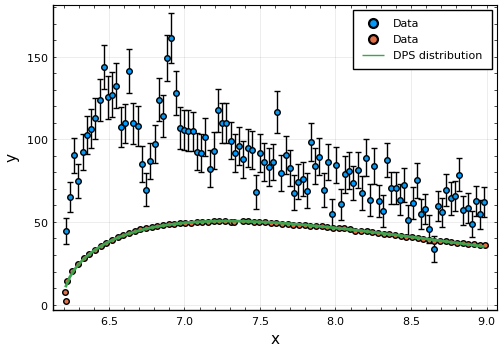

In [14]:
@plt_data data_full
@plt_best! dpsmodel dpsfit_poly dps_data label="DPS distribution" lw=2

In [4]:
# redefine sqrt so that its cut is along the positive x axis
function xsqrt(x)
    imag(x) >=0 ? sqrt(x+0im) : -sqrt(x-0im)
end

ρ(w,m1,m2) = xsqrt(qsq(w,m1,m2)+0im)/(8π*w);

In [5]:
# two-point loop function from dim. reg. with a subtraction constant
function Gdr(w, m1, m2, a=-3)
    μ = 1.0; s = w^2; Δ = m1^2-m2^2
	qcm = xsqrt(λ(s, m1^2, m2^2)+0im)/(2w)
    return @fastmath 1/(16π^2) * (a + 2log(m1/μ) + 2(m2^2-m1^2+s)/(2s)*log(m2/m1) + qcm/w *
    (log(s-Δ+2qcm*w) + log(s+Δ+2qcm*w) - log(-s+Δ+2qcm*w) - log(-s-Δ+2qcm*w) ) )
end

Gdr (generic function with 2 methods)

In [3]:
# can be installed in REPL by ]add https://github.com/fkguo/LoopTools.jl
using LoopTools  # for checking

Glt(w, m1, m2, a=-3) = (a + 2 - B0(w^2, m1^2, m2^2))/(16π^2)

SyntaxError: invalid syntax (<ipython-input-3-14122c34aec6>, line 2)

In [13]:
?B0

search: B00 B001 bb00 bb001 B0 B0i DB0 DB00 bb0 dbb0 dbb00 dbb001



```
B0(p^2, m1^2, m2^2)
```

the scalar two-point one-loop function

$$
\frac{μ^{4-D}}{iπ^{D/2} r_Γ} \int
\frac{d^D q }{(q^2-m_1^2)\left[(q+p)^2-m_2^2\right]}
$$

with $r_Γ = \frac{Γ^2(1-ε)Γ(1+ε)}{Γ(1-2ε)}$, $D=4-2ε$.


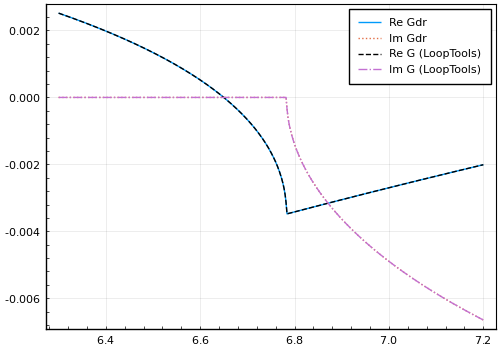

In [17]:
let xv = 6.3:0.002:7.2, a =-3, m1 = mjψ, m2=mψp
    plot(xv, x->real(Gdr(x,m1,m2,a)), label="Re Gdr")
    plot!(xv, x->imag(Gdr(x,m1,m2)), line=:dot, label="Im Gdr")
    plot!(xv, x->real(Glt(x,m1,m2,a)), line=:dash, label="Re G (LoopTools)", c=:black)
    plot!(xv, x->imag(Glt(x,m1,m2)), line=:dashdot, label="Im G (LoopTools)")
end

In [2]:
# can be installed in REPL by ]add https://github.com/fkguo/LoopTools.jl
using LoopTools  # for checking

mds=1.96834
mdsstar=2.00685
mds_doublestar=3.25

c0(x) = -C0(1.02^2, x^2, 5.28^2, mds_doublestar^2, mds^2, mdstar^2 )

plot(3.5:0.001:4.5, x-> real(c0(x)), label="Re" )
plot!(3.5:0.001:4.5, x-> imag(c0(x)), label="Im" )

SyntaxError: invalid syntax (<ipython-input-2-8210dbe38429>, line 2)

## Fits with two channels: $J/\psi J/\psi$, $\psi' J/\psi$

In the following, we use the dim reg loop integral

In [6]:
# T matrix elements (T11, T12, T22) in 4 Riemann sheets, default to the 1st sheet
function T(w, par, rs::Integer=1)
    a1, a2, c, b1, b2 = par
    
    v11 = (a1 + b1*qsq(w, mjψ, mjψ)) * 4mjψ^2
    v22 = (a2 + b2*qsq(w, mψp, mjψ)) * 4mjψ*mψp
    v12 = c * 4mjψ*sqrt(mjψ*mψp)
    v21 = v12

    g11 = Gdr(w, mjψ, mjψ)
    g22 = Gdr(w, mψp, mjψ)
    
    if rs == 1
        nothing
    elseif rs == 2
        g11 += 2im *ρ(w,mjψ,mjψ)
    elseif rs == 3
        g11 += 2im *ρ(w,mjψ,mjψ)
        g22 += 2im *ρ(w,mψp,mjψ)
    elseif rs == 4
        g22 += 2im *ρ(w,mψp,mjψ)
    else
        error("rs should be 1, 2, 3 or 4.")
    end
    
    num11 = -g22*v11*v22 + g22*v12^2 + v11
    num12 = v12
    num22 = g11*(v12^2-v11*v22) + v22
    den = 1 - g11*num11 - g22*v22
    
    return (num11/den, num12/den, num22/den)
end

T (generic function with 2 methods)

In [20]:
# determinant of the denorminator of T-amtrix, for pole searching
function tdet!(F, x, pars, rs)
    w = x[1] + 1im*x[2]

    a1, a2, c, b1, b2 = pars  

    v11 = (a1 + b1*qsq(w, mjψ, mjψ)) * 4mjψ^2
    v22 = (a2 + b2*qsq(w, mψp, mjψ)) * 4mjψ*mψp
    v12 = c * 4mjψ*sqrt(mjψ*mψp)

    g11 = Gdr(w, mjψ, mjψ)
    g22 = Gdr(w, mψp, mjψ)

    if rs == 1
        nothing
    elseif rs == 2
        g11 += 2im *ρ(w,mjψ,mjψ)
    elseif rs == 3
        g11 += 2im *ρ(w,mjψ,mjψ)
        g22 += 2im *ρ(w,mψp,mjψ)
    elseif rs == 4
        g22 += 2im *ρ(w,mψp,mjψ)
    else
        error("rs should be 1, 2, 3 or 4.")
    end
    num1 = -g22*v11*v22 + g22*v12^2 + v11
    den = 1 - g11*num1 - g22*v22
    
    F[1] = real(den)
    F[2] = imag(den)
end

function tdet!(F, x, fit::AbstractFit, rs)
    pars = args(fit)
    tdet!(F, x, pars, rs)
end

tdet! (generic function with 2 methods)

In [23]:
# search for poles with parameters from fit in all four Riemann sheets
function poles(pars; init_val = [6.85, 0.1])
    _cont = Vector{ComplexF64}(undef, 4)
    for i = 1:4
        sol = nlsolve((F,x) -> tdet!(F,x, pars, i), init_val)
        _cont[i] = sol.residual_norm < 1e-8 ? complex(sol.zero[1], sol.zero[2]) : NaN+1im*NaN
    end
    return  DataFrame([1:4, _cont], [:sheet, :pole])
end

function poles(whichfit::T; kwds...) where T <: Union{Symbol, Expr}
    pars = args(eval(whichfit))
    println("Pole positions for $whichfit:")
    return poles(pars; kwds...)
end

poles(fit::ArrayFit; kwds...) = poles(args(fit); kwds...)

poles (generic function with 3 methods)

In [57]:
# for this function to work properly, Plots version should be <=1.6.5
function plt_tmatrix(whichfit::S; zup=500) where S <: Union{Symbol, Expr}
    fit = eval(whichfit)
    
    pars = args(fit)[1:5]

    tij(x,y,rs) = T(x + 1im*y, pars, rs)[2]
    
    x = 6.15:0.002:6.95
    y = -0.35:0.002:0.35
    
    gr()   
    plt_rs(rs) = plot(x, y, (a,b)->abs(tij(a,b,rs)), zlim=(0,zup), st=[:surface, :contourf], c=:GnBu_3, 
        camera=(30,30), title="Riemann sheet $rs", legend=false, layout=2, titlefont = (10, "times")) 

    p11 = plt_rs(1); p2 = plt_rs(2); p3 = plt_rs(3); p4 = plt_rs(4)
    
    title = plot(title = "Amplitude of J/ψ ψ' → J/ψ J/ψ for $whichfit", titlefont = (12, "serif"), 
            grid = false, showaxis = false, bottom_margin = -60Plots.px)
    plot(title, p11, p2, p3, p4, size=(880,450), layout = @layout([A{0.1h}; [B C; D E]]))
end 

plt_tmatrix (generic function with 1 method)

In [24]:
# default production vertex to α*exp(-β*s)
function dist(w, par, prod = (α,β,s)->α*exp(-β*s))
    if typeof(par) <: AbstractArray
        npar = length(par)
        t11, t21 = T(w, view(par, 1:5))
        α, β, r, bg, ct = view(par, (npar-4):npar)
    elseif typeof(par) <: Tuple
        a1, a2, c, b1, b2, α, β, r, bg, ct = par
        t11, t21 = T(w, par)
    else
        error("typeof(par) = $(typeof(par)); it has to be either an Array or a Tuple.")
    end
    
    s = w^2
    g1 = Gdr(w, mjψ, mjψ)
    g2 = Gdr(w, mψp, mjψ)

    amp = prod(α,β,s) * (ct + g1*t11 + r*g2*t21) 
    
    return phsp(w,mjψ,mjψ) * (abs2(amp) + bg)
end

dist (generic function with 2 methods)

In [26]:
# fit with production vertex of the exponential type
pro_exp(a,b,s) = a*exp(-b*s)

const parname = [:a1, :a2, :c, :b1, :b2, :alpha, :beta, :r, :bg, :ct]
const parname_3c = [:a11, :a12, :a13, :a22, :a23, :a33, :alpha, :beta, :r1, :r2, :bg, :ct]

const ndata = 36;

In [27]:
function makefit(fit::AbstractFit; dof=28, printout=true)
    migrad(fit); migrad(fit); hesse(fit)
    printout && println("χ²/dof = ", fit.fval/dof)
    migrad(fit)
end

function do_minos(fit)
    migrad(fit); minos(fit); migrad(fit)
end

do_minos (generic function with 1 method)

What would be the proper initial values of the parameters?
* Choose initial values randomly
* Keep only initial values satisfying the following conditions
 - leading to a fit with χ²/dof < 1.25
 - causality: the only pole allowed in the first Riemann sheet is bound state pole on the real axis below the double-J/ψ threshold

In [28]:
"""
    search_init_rand(fun, data; nrand=100, dof=28, onlynan=false, nchannels=2, par...)

search for proper initial values for the LECs with Monte Carlo in the range [-50, 50].
* keep only the initial values leading to a fit with χ²/dof < 1.25 and that the corresponding 
1st sheet pole is not found if `onlynan=true` or the im part is larger than 0.3 GeV if `onlynan=false`; 
real pole on 1st sheet is kept.
* `nchannels=2` for two channels and `nchannels=3` for three channels 
"""
function search_init_rand(fun, data; nrand=100, dof=28, onlynan=false, nchannels=2, par...)
    df = DataFrame(chisq = Real[], lecs_init = Tuple[], lecs_final = Tuple[])   
    nlecs = nchannels == 3 ? 6 : 5
    ar = zeros(nlecs)
    
    for i = 1:nrand
        ar .= rand(-50:0.1:50, nlecs)
        if nchannels == 2
            _initval = (ar..., 433, 12.336e-3, 1, 0, 1)
            _fit = model_fit(fun, data, _initval; name=parname, fix_beta=true, fix_r=true, fix_bg=true, par...)
        elseif nchannels == 3
            _initval = (ar..., 433, 12.336e-3, 1, 1, 0, 1)
            _fit = model_fit(fun, data, _initval; name=parname_3c, 
                   fix_beta=true, fix_r1=true, fix_r2=true, fix_bg=true, par...)
        end
        _fit.strategy = 2
        migrad(_fit); migrad(_fit)
        _chsq = _fit.fval/dof
        
        # search for pole in the 1st sheet (RS1)
        if nchannels == 2 
            _sol = nlsolve((F,x) -> tdet!(F,x, _fit, 1), [6.85,0.15])
        elseif nchannels == 3 
            _sol = nlsolve((F,x) -> tdet_3c!(F,x, _fit, 111), [6.85,0.15])
        end
        _pole = _sol.residual_norm < 1e-8 ? complex(_sol.zero[1], _sol.zero[2]) : NaN+1im*Inf
        
        nancondition = isnan(real(_pole)) | (abs(imag(_pole)) < 1e-8)
        
        _condition = onlynan ? nancondition : ((abs(imag(_pole))>0.3) | (abs(imag(_pole)) < 1e-8))    
        (_chsq < 1.25) & _condition && push!(df, (round(_chsq, digits=4), _initval, Tuple(args(_fit))) )
    end
    
    sort!(df)
    return unique!(df, :chisq)
end

search_init_rand

### Fit with 5 parameters for T-matrix

* Contact terms:

\begin{align}
V_{11}=&\, 4m_{J/\psi}^2(a_1+b_1 k_1^2),\ \ V_{12}=V_{21}=4m_{J/\psi}\sqrt{m_{J/\psi}m_{\psi'}}c,\notag\\
V_{22}=&\, 4m_{J/\psi}m_{\psi'}(a_2+b_2 k_2^2).
\end{align}

* Free parameters: $$a_1, a_2, c, b_1, b_2, \alpha.$$ 
all $r_i$'s in the production amplitude are fixed to be the same (realized in the code by setting $r=1$).

* Use 20000 random initial values to get some fits with small $\chi^2$ and satisfying the causality constraint.

In [28]:
@time search_init_rand(dist, data_full[1:ndata], nrand=100, dof=29, onlynan=true)

  8.473870 seconds (15.89 M allocations: 705.185 MiB, 3.59% gc time)


1×3 DataFrame. Omitted printing of 1 columns
│ Row │ chisq  │ lecs_init                                                │
│     │ Real   │ Tuple                                                    │
├─────┼────────┼──────────────────────────────────────────────────────────┤
│ 1   │ 1.1021 │ (27.4, 11.6, 16.3, -25.1, -28.5, 433, 0.012336, 1, 0, 1) │

In [558]:
# @time df_initval_2c_nan20000 = search_init_rand(dist, data_full[1:ndata], nrand=20000, dof=29, onlynan=true)

1633.776746 seconds (3.01 G allocations: 131.042 GiB, 2.85% gc time)


29×3 DataFrame. Omitted printing of 1 columns
│ Row │ chisq  │ lecs_init                                                  │
│     │ Real   │ Tuple                                                      │
├─────┼────────┼────────────────────────────────────────────────────────────┤
│ 1   │ 0.9889 │ (8.2, -41.2, 17.0, -5.7, -47.7, 433, 0.012336, 1, 0, 1)    │
│ 2   │ 0.9899 │ (-27.2, -23.7, 26.8, -10.9, -10.4, 433, 0.012336, 1, 0, 1) │
│ 3   │ 0.9953 │ (2.2, -34.1, 38.4, -30.6, 17.7, 433, 0.012336, 1, 0, 1)    │
│ 4   │ 1.0069 │ (-36.9, -14.8, 26.9, -11.6, -10.4, 433, 0.012336, 1, 0, 1) │
│ 5   │ 1.0101 │ (-5.0, -2.6, 14.0, -9.5, -31.0, 433, 0.012336, 1, 0, 1)    │
│ 6   │ 1.0462 │ (28.3, -10.7, -14.5, -43.5, -8.6, 433, 0.012336, 1, 0, 1)  │
│ 7   │ 1.0511 │ (-37.7, -33.6, 42.8, -13.1, -13.7, 433, 0.012336, 1, 0, 1) │
│ 8   │ 1.0845 │ (16.6, -39.4, 37.6, -34.1, -22.2, 433, 0.012336, 1, 0, 1)  │
│ 9   │ 1.1018 │ (-37.6, 28.0, 3.2, -49.8, -35.0, 433, 0.012336, 1, 0, 1)   │
│ 10  │ 1.102  │ (34.2, 33.4, 13.2, -42.2, -31.8, 433, 0.012336, 1, 0, 1)   │
⋮
│ 19  │ 1.2136 │ (5.8, 33.6, 20.7, -16.3, -44.7, 433, 0.012336, 1, 0, 1)    │
│ 20  │ 1.2181 │ (28.7, 11.3, -43.8, 10.6, 46.9, 433, 0.012336, 1, 0, 1)    │
│ 21  │ 1.2186 │ (9.7, -29.3, 1.5, 43.2, 43.1, 433, 0.012336, 1, 0, 1)      │
│ 22  │ 1.2206 │ (39.3, -44.1, -10.4, 47.5, 36.8, 433, 0.012336, 1, 0, 1)   │
│ 23  │ 1.2229 │ (18.9, -28.1, -13.5, 7.6, 36.9, 433, 0.012336, 1, 0, 1)    │
│ 24  │ 1.2263 │ (-47.7, 3.0, -19.7, 36.9, 17.0, 433, 0.012336, 1, 0, 1)    │
│ 25  │ 1.232  │ (-3.8, -47.2, 38.5, -7.2, 25.6, 433, 0.012336, 1, 0, 1)    │
│ 26  │ 1.2328 │ (8.9, 5.9, 9.7, -6.6, -48.2, 433, 0.012336, 1, 0, 1)       │
│ 27  │ 1.2432 │ (-4.2, -26.8, -3.0, 10.3, 49.4, 433, 0.012336, 1, 0, 1)    │
│ 28  │ 1.2489 │ (-6.8, 48.5, 38.5, 41.0, -37.5, 433, 0.012336, 1, 0, 1)    │
│ 29  │ 1.2499 │ (-40.9, -4.5, -33.0, 41.8, 17.9, 433, 0.012336, 1, 0, 1)   │

In [11]:
# read parameters from file, and parse strings into tuples for the parameter sets
function read_file(file::String; cols=(:lecs_init, :lecs_final))
    df = DataFrame!(CSV.File(file))
    for col in cols
        df[col] = map(x->eval(Meta.parse(x)), df[col])
    end
    return df
end

read_file (generic function with 1 method)

In [10]:
# CSV.write("data/df_initval_2c_nan20000.csv", df_initval_2c_nan20000)
df_initval_2c_nan20000 = read_file("data/df_initval_2c_nan20000.csv")

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = read_file(::String; cols::Tuple{Symbol,Symbol}) at In[9]:5
└ @ Main .\In[9]:5
┌ Warning: `setindex!(df::DataFrame, v::AbstractVector, col_ind::ColumnIndex)` is deprecated, use `begin
│     df[!, col_ind] = v
│     df
│ end` instead.
│   caller = read_file(::String; cols::Tuple{Symbol,Symbol}) at In[9]:5
└ @ Main .\In[9]:5


29×3 DataFrame. Omitted printing of 1 columns
│ Row │ chisq   │ lecs_init                                                  │
│     │ Float64 │ Tuple…                                                     │
├─────┼─────────┼────────────────────────────────────────────────────────────┤
│ 1   │ 0.9889  │ (8.2, -41.2, 17.0, -5.7, -47.7, 433, 0.012336, 1, 0, 1)    │
│ 2   │ 0.9899  │ (-27.2, -23.7, 26.8, -10.9, -10.4, 433, 0.012336, 1, 0, 1) │
│ 3   │ 0.9953  │ (2.2, -34.1, 38.4, -30.6, 17.7, 433, 0.012336, 1, 0, 1)    │
│ 4   │ 1.0069  │ (-36.9, -14.8, 26.9, -11.6, -10.4, 433, 0.012336, 1, 0, 1) │
│ 5   │ 1.0101  │ (-5.0, -2.6, 14.0, -9.5, -31.0, 433, 0.012336, 1, 0, 1)    │
│ 6   │ 1.0462  │ (28.3, -10.7, -14.5, -43.5, -8.6, 433, 0.012336, 1, 0, 1)  │
│ 7   │ 1.0511  │ (-37.7, -33.6, 42.8, -13.1, -13.7, 433, 0.012336, 1, 0, 1) │
│ 8   │ 1.0845  │ (16.6, -39.4, 37.6, -34.1, -22.2, 433, 0.012336, 1, 0, 1)  │
│ 9   │ 1.1018  │ (-37.6, 28.0, 3.2, -49.8, -35.0, 433, 0.012336, 1, 0, 1)   │
│ 10  │ 1.102   │ (34.2, 33.4, 13.2, -42.2, -31.8, 433, 0.012336, 1, 0, 1)   │
⋮
│ 19  │ 1.2136  │ (5.8, 33.6, 20.7, -16.3, -44.7, 433, 0.012336, 1, 0, 1)    │
│ 20  │ 1.2181  │ (28.7, 11.3, -43.8, 10.6, 46.9, 433, 0.012336, 1, 0, 1)    │
│ 21  │ 1.2186  │ (9.7, -29.3, 1.5, 43.2, 43.1, 433, 0.012336, 1, 0, 1)      │
│ 22  │ 1.2206  │ (39.3, -44.1, -10.4, 47.5, 36.8, 433, 0.012336, 1, 0, 1)   │
│ 23  │ 1.2229  │ (18.9, -28.1, -13.5, 7.6, 36.9, 433, 0.012336, 1, 0, 1)    │
│ 24  │ 1.2263  │ (-47.7, 3.0, -19.7, 36.9, 17.0, 433, 0.012336, 1, 0, 1)    │
│ 25  │ 1.232   │ (-3.8, -47.2, 38.5, -7.2, 25.6, 433, 0.012336, 1, 0, 1)    │
│ 26  │ 1.2328  │ (8.9, 5.9, 9.7, -6.6, -48.2, 433, 0.012336, 1, 0, 1)       │
│ 27  │ 1.2432  │ (-4.2, -26.8, -3.0, 10.3, 49.4, 433, 0.012336, 1, 0, 1)    │
│ 28  │ 1.2489  │ (-6.8, 48.5, 38.5, 41.0, -37.5, 433, 0.012336, 1, 0, 1)    │
│ 29  │ 1.2499  │ (-40.9, -4.5, -33.0, 41.8, 17.9, 433, 0.012336, 1, 0, 1)   │

* A fit can be done step by step, by limiting/fixing some parameters first and then releasing the constraints later

In [33]:
# let's try with fixed c and limiting a1 to a range
fittest = model_fit(dist, data_full[1:ndata], df_initval_2c_nan20000.lecs_init[1], name=parname, 
                 fix_r=true, fix_beta=true, fix_bg=true, fix_c=true, limit_a1=[-100,100])
fittest.strategy = 2;
makefit(fittest, dof=ndata-7)

χ²/dof = 2.674129619129626


PyObject MigradResult(fmin=FMin(fval=77.54975893828288, edm=2.6851442432171344e-12, tolerance=0.1, nfcn=94, ncalls=1042, up=1.0, is_valid=True, has_valid_parameters=True, has_accurate_covar=True, has_posdef_covar=True, has_made_posdef_covar=False, hesse_failed=False, has_covariance=True, is_above_max_edm=False, has_reached_call_limit=False, has_parameters_at_limit=False), params=[Param(number=0, name='a1', value=-1.563140625695695, error=0.4803322344576486, is_const=False, is_fixed=False, has_limits=True, has_lower_limit=True, has_upper_limit=True, lower_limit=-100.0, upper_limit=100.0), Param(number=1, name='a2', value=-56.252271486429464, error=4.957271589999785, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=2, name='c', value=17.0, error=0.17, is_const=False, is_fixed=True, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=3, name='b1', value=-3.756378441633688, error=0.45888960049740557, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=4, name='b2', value=-211.57997187012626, error=15.373622496606766, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=5, name='alpha', value=230.83455493483945, error=25.911858690625728, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=6, name='beta', value=0.012336, error=0.00012336, is_const=False, is_fixed=True, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=7, name='r', value=1.0, error=0.01, is_const=False, is_fixed=True, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=8, name='bg', value=0.0, error=0.1, is_const=False, is_fixed=True, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=9, name='ct', value=0.15536165200208235, error=0.10962458286855267, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None)])

In [34]:
# fit can be continued from the previous fit
fittest2 = model_fit(dist, data_full[1:ndata], fittest, name=parname, fix_c=false, limit_a1=nothing)
fittest2.strategy = 2;
makefit(fittest2, dof=ndata-7)

χ²/dof = 0.9889308576129993


PyObject MigradResult(fmin=FMin(fval=28.678994870741143, edm=5.007382798982243e-13, tolerance=0.1, nfcn=108, ncalls=948, up=1.0, is_valid=True, has_valid_parameters=True, has_accurate_covar=True, has_posdef_covar=True, has_made_posdef_covar=False, hesse_failed=False, has_covariance=True, is_above_max_edm=False, has_reached_call_limit=False, has_parameters_at_limit=False), params=[Param(number=0, name='a1', value=-1.1036953745599125, error=0.16623252326659516, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=1, name='a2', value=-18.345487830664638, error=6.617879869138935, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=2, name='c', value=9.410883414321175, error=0.9897790409025552, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=3, name='b1', value=-0.8019470198941265, error=0.24822730395485965, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=4, name='b2', value=-179.1880629431513, error=21.11786027891731, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=5, name='alpha', value=317.9702928412457, error=4.269222706833673, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=6, name='beta', value=0.012336, error=0.00012336, is_const=False, is_fixed=True, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=7, name='r', value=1.0, error=0.01, is_const=False, is_fixed=True, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=8, name='bg', value=0.0, error=0.1, is_const=False, is_fixed=True, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=9, name='ct', value=0.49122250580387794, error=0.024009717820718465, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None)])

In [35]:
# compute asymmetric errors using MINOS taking into account correlation and nonlinearity
minos(fittest2)

PyObject MErrors([('a1', MError(name='a1', is_valid=True, lower=-0.16253398981170758, upper=0.17077132591543115, lower_valid=True, upper_valid=True, at_lower_limit=False, at_upper_limit=False, at_lower_max_fcn=False, at_upper_max_fcn=False, lower_new_min=False, upper_new_min=False, nfcn=247, min=-1.1036953745599125)), ('a2', MError(name='a2', is_valid=True, lower=-6.824377934469544, upper=6.250127864901334, lower_valid=True, upper_valid=True, at_lower_limit=False, at_upper_limit=False, at_lower_max_fcn=False, at_upper_max_fcn=False, lower_new_min=False, upper_new_min=False, nfcn=275, min=-18.345487830664638)), ('c', MError(name='c', is_valid=True, lower=-1.0377752767947344, upper=0.9706420568031746, lower_valid=True, upper_valid=True, at_lower_limit=False, at_upper_limit=False, at_lower_max_fcn=False, at_upper_max_fcn=False, lower_new_min=False, upper_new_min=False, nfcn=222, min=9.410883414321175)), ('b1', MError(name='b1', is_valid=True, lower=-0.26026137718814346, upper=0.239178768161551, lower_valid=True, upper_valid=True, at_lower_limit=False, at_upper_limit=False, at_lower_max_fcn=False, at_upper_max_fcn=False, lower_new_min=False, upper_new_min=False, nfcn=261, min=-0.8019470198941265)), ('b2', MError(name='b2', is_valid=True, lower=-21.31489800587498, upper=21.007850431420227, lower_valid=True, upper_valid=True, at_lower_limit=False, at_upper_limit=False, at_lower_max_fcn=False, at_upper_max_fcn=False, lower_new_min=False, upper_new_min=False, nfcn=275, min=-179.1880629431513)), ('alpha', MError(name='alpha', is_valid=True, lower=-4.385629338634984, upper=4.286718418761612, lower_valid=True, upper_valid=True, at_lower_limit=False, at_upper_limit=False, at_lower_max_fcn=False, at_upper_max_fcn=False, lower_new_min=False, upper_new_min=False, nfcn=144, min=317.9702928412457)), ('ct', MError(name='ct', is_valid=True, lower=-0.02472127324459802, upper=0.023770733075721848, lower_valid=True, upper_valid=True, at_lower_limit=False, at_upper_limit=False, at_lower_max_fcn=False, at_upper_max_fcn=False, lower_new_min=False, upper_new_min=False, nfcn=182, min=0.49122250580387794))])

In [36]:
migrad(fittest2)

PyObject MigradResult(fmin=FMin(fval=28.67899487074111, edm=5.012092232100062e-13, tolerance=0.1, nfcn=108, ncalls=2662, up=1.0, is_valid=True, has_valid_parameters=True, has_accurate_covar=True, has_posdef_covar=True, has_made_posdef_covar=False, hesse_failed=False, has_covariance=True, is_above_max_edm=False, has_reached_call_limit=False, has_parameters_at_limit=False), params=[Param(number=0, name='a1', value=-1.1036953745514888, error=0.16623251880693626, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=1, name='a2', value=-18.345487834964725, error=6.617879789149009, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=2, name='c', value=9.41088341465719, error=0.9897790235911332, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=3, name='b1', value=-0.8019470198676543, error=0.24822728826446683, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=4, name='b2', value=-179.1880629563325, error=21.117860172555922, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=5, name='alpha', value=317.9702928412611, error=4.269222675131433, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=6, name='beta', value=0.012336, error=0.00012336, is_const=False, is_fixed=True, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=7, name='r', value=1.0, error=0.01, is_const=False, is_fixed=True, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=8, name='bg', value=0.0, error=0.1, is_const=False, is_fixed=True, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=9, name='ct', value=0.4912225058052533, error=0.024009717574985323, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None)])

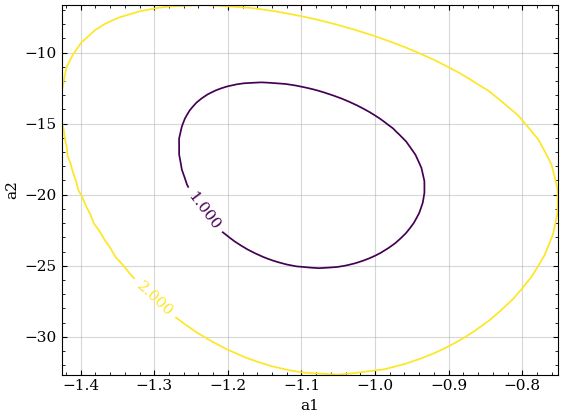

  2.728501 seconds (1.64 M allocations: 73.967 MiB, 2.10% gc time)


PyObject <matplotlib.contour.ContourSet object at 0x7f315fd7ab50>

In [37]:
@time fittest2.draw_mncontour(:a1, :a2)

* Perform fits for all the chosen initial values and compare with the data
* Most of the fits have very narrow spikes, which should be unphysical
* Pick out only those behaving well; they basically lead to the same best fit

In [38]:
nfits = nrow(df_initval_2c_nan20000)
fits_2c = Vector(undef, nfits)
@time for i in 1:nfits
    fits_2c[i] = model_fit(dist, data_full[1:ndata], df_initval_2c_nan20000.lecs_init[i], 
                           name=parname, fix_r=true, fix_beta=true, fix_bg=true)
    fits_2c[i].strategy = 2;
    makefit(fits_2c[i], dof=ndata-7, printout=false)
end

  5.217159 seconds (4.71 M allocations: 213.017 MiB, 1.98% gc time)


  1.041745 seconds (2.03 M allocations: 57.068 MiB, 7.96% gc time)


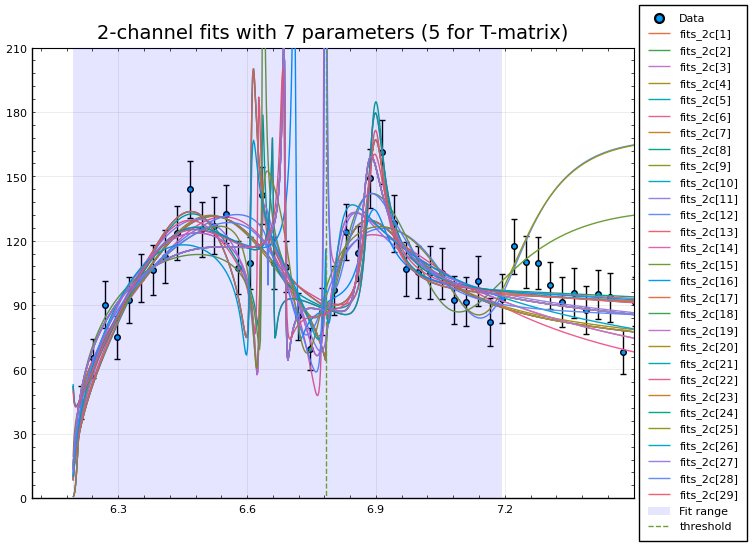

In [40]:
pyplot(size=(750,500))
@plt_data data_full xlim=(6.1,7.5) ylim=(0, 210) label="Data"
@time for i = 1:nfits
    plot!(6.195:0.002:9.2, x->dist(x, args(fits_2c[i])), label="fits_2c[$i]")
end
vspan!([2*mjψ, data_full.:x[ndata]], alpha=0.1, label="Fit range", c="blue")
vline!([mjψ+mψp], line=:dash, label="threshold")
plot!(title="2-channel fits with 7 parameters (5 for T-matrix)", legend=:outerright)

In [41]:
# pick out the fits that do not have the suspicious spikes
function reasonable_pars(fun, fits; nchannels=2)
    sets = []
    n = 200
    xv = LinRange(6.6, 6.85, n)
    xv2 = LinRange(6.602, 6.8502, n)
    ar = Vector{Float64}(undef, n)
    for i in eachindex(fits)
        _fit = fits[i]
        pars = args(_fit)
        ar .= fun.(xv, Ref(pars))
        _min, _max = extrema(ar)
        ar .= (fun.(xv, Ref(pars)) .- fun.(xv2, Ref(pars))); _max2 = maximum(abs.(ar))
        df = nchannels==2 ? poles(_fit, init_val=[6.6,0.001]) : poles_3c(_fit, init_val=[6.6,0.001])

        pole_criteria = isnan(real(df.pole[1])) | (abs(imag(df.pole[1])) < 1e-8)
        (_max - _min < 90) & (_max2 < 10) & pole_criteria && push!(sets, i)
    end
    return Tuple(sets)
end

reasonable_pars (generic function with 1 method)

In [42]:
goodsets_2c = reasonable_pars(dist, fits_2c)

(2, 3, 4, 5, 7)

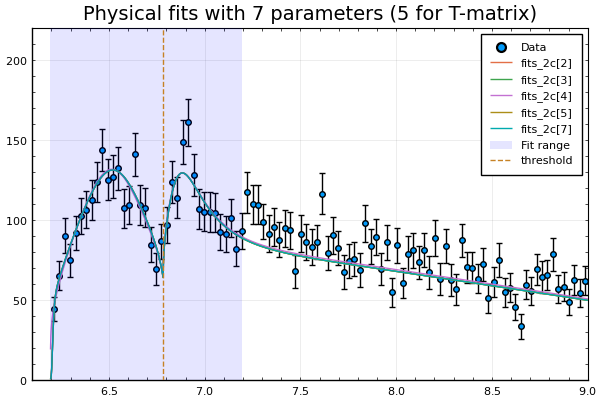

In [43]:
# it turns out that only [2:5,7] sets give line shapes wihout any spikes
# they basically give the same fit
@plt_data data_full xlim=(6.1,9) ylim=(0, 220) label="Data"
for i = goodsets_2c
    plot!(6.195:0.002:9.2, x->dist(x, args(fits_2c[i])), label="fits_2c[$i]")
end
vspan!([2*mjψ, data_full.:x[ndata]], alpha=0.1, label="Fit range", c="blue")
vline!([mjψ+mψp], line=:dash, label="threshold")
plot!(title="Physical fits with 7 parameters (5 for T-matrix)", size=(600,400))

In [44]:
# only set-4 gives slightly different central values for some paras, also a bit larger χ²
do_minos(fits_2c[2])

PyObject MigradResult(fmin=FMin(fval=28.70817446152091, edm=1.0436723260215195e-11, tolerance=0.1, nfcn=118, ncalls=4922, up=1.0, is_valid=True, has_valid_parameters=True, has_accurate_covar=True, has_posdef_covar=True, has_made_posdef_covar=False, hesse_failed=False, has_covariance=True, is_above_max_edm=False, has_reached_call_limit=False, has_parameters_at_limit=False), params=[Param(number=0, name='a1', value=0.19339490995587302, error=0.5356124134510161, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=1, name='a2', value=-4.1833255035428945, error=0.6571481273872228, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=2, name='c', value=2.942520439737729, error=0.30502177636834066, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=3, name='b1', value=-1.7547629742540691, error=0.4346603950580383, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=4, name='b2', value=-7.105169718924432, error=0.3746280906098501, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=5, name='alpha', value=69.85303352247769, error=7.994336344693322, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=6, name='beta', value=0.012336, error=0.00012336, is_const=False, is_fixed=True, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=7, name='r', value=1.0, error=0.01, is_const=False, is_fixed=True, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=8, name='bg', value=0.0, error=0.1, is_const=False, is_fixed=True, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=9, name='ct', value=3.252526070795858, error=0.3969713044269994, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None)])

* Correlation matrix for the parameters can be computed:

In [42]:
matrix(fits_2c[3], correlation=true)

PyObject ((1.0, 0.3299436886169677, 0.2489472697938397, -0.823939468637425, 0.2390098585716998, -0.08149470368647793, 0.1646313196499067), (0.3299436886169677, 1.0, -0.04462391953573969, -0.4547401141716068, 0.9654579128158013, -0.2756917537591883, 0.31862591674758767), (0.2489472697938397, -0.04462391953573969, 1.0, -0.4997653642090599, -0.21177032683845037, -0.1853084447680238, 0.24975482125741172), (-0.823939468637425, -0.4547401141716068, -0.4997653642090599, 1.0, -0.3460812087545956, 0.4458475207374961, -0.5475840910683468), (0.2390098585716998, 0.9654579128158013, -0.21177032683845037, -0.3460812087545956, 1.0, -0.3020356140502874, 0.32623889551093527), (-0.08149470368647793, -0.2756917537591883, -0.1853084447680238, 0.4458475207374961, -0.3020356140502874, 1.0, -0.9890405304734528), (0.1646313196499067, 0.31862591674758767, 0.24975482125741172, -0.5475840910683468, 0.32623889551093527, -0.9890405304734528, 1.0))

* Search for poles on all four Riemann sheets for the best fit

| sheet | [Sgn(Im$p_1$), Sgn(Im$p_2$)]| poles |
|--|--|--|
| 1 | $[++]$ | no pole|
| 2 | $[-+]$ | a near-threshold pole + a pole with a large imaginary part |
| 3 | $[--]$ | a pole nearby 6.8 GeV + a pole with a large imaginary part (remote) |
| 4 | $[+-]$ | a pole nearby 6.8 GeV (remote) |

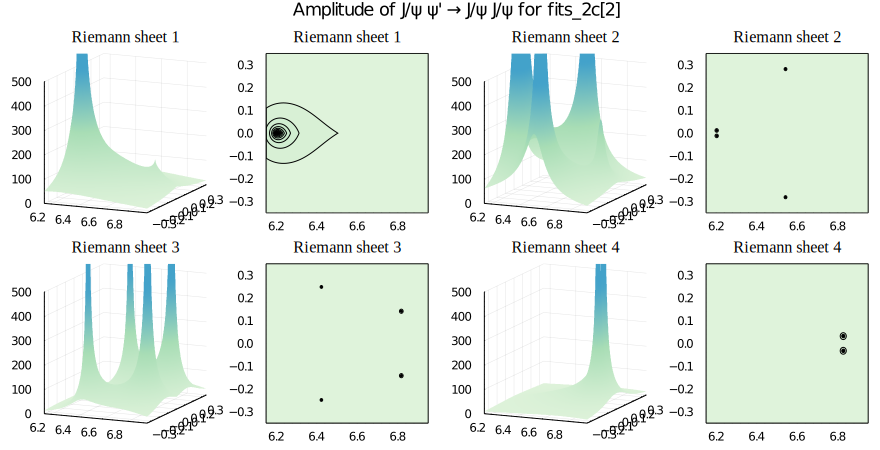

In [58]:
plt_tmatrix(:(fits_2c[2]))

In [46]:
poles(:(fits_2c[2]), init_val=[6.8,0.1])

Pole positions for fits_2c[2]:


4×2 DataFrame
│ Row │ sheet │ pole                │
│     │ Int64 │ Complex{Float64}    │
├─────┼───────┼─────────────────────┤
│ 1   │ 1     │ NaN+NaN*im          │
│ 2   │ 2     │ 6.54205-0.281574im  │
│ 3   │ 3     │ 6.81757+0.141629im  │
│ 4   │ 4     │ 6.82722+0.0325427im │

In [47]:
poles(:(fits_2c[2]), init_val=[6.2,0.1])

Pole positions for fits_2c[2]:


4×2 DataFrame
│ Row │ sheet │ pole                │
│     │ Int64 │ Complex{Float64}    │
├─────┼───────┼─────────────────────┤
│ 1   │ 1     │ NaN+NaN*im          │
│ 2   │ 2     │ 6.2026+0.011616im   │
│ 3   │ 3     │ 6.42288+0.248313im  │
│ 4   │ 4     │ 6.82722+0.0325427im │

### Error analysis

* generating more than 300 parameter sets within $1\sigma$

In [49]:
function poles_error_analysis(parsdf::DataFrame)
    _df = DataFrame(pole_rs1=Complex[], pole_rs2_low=Complex[], 
            pole_rs2_high = Complex[], pole_rs3 = Complex[]) # 
    _cont = Vector{ComplexF64}(undef, 4)
    for dfrow in eachrow(parsdf)
        for i = 1:2 # pole in the 1 and 2 sheets with a low initial value
            sol = nlsolve((F,x) -> tdet!(F,x, Vector(dfrow[2:end]), i), [6.1, 0.001])
            _cont[i] = sol.residual_norm < 1e-8 ? complex(sol.zero[1], sol.zero[2]) : NaN+1im*NaN
        end
        for i = 2:3 # pole in the 2 and 3 sheets with a high initial value
            sol = nlsolve((F,x) -> tdet!(F,x, Vector(dfrow[2:end]), i), [6.8, 0.1])
            _cont[i+1] = sol.residual_norm < 1e-8 ? complex(sol.zero[1], sol.zero[2]) : NaN+1im*NaN
        end
        push!(_df, _cont)
    end
    return _df
end

poles_error_analysis (generic function with 1 method)

In [50]:
chisq_2c(par) = chisq(dist, data_full[1:ndata], par)

chisq_2c (generic function with 1 method)

In [51]:
fit_ea_2c = Minuit(chisq_2c, fits_2c[2]; name = parname, fix_r=true, fix_beta=true, fix_bg=true)
fit_ea_2c.strategy = 2;
makefit(fit_ea_2c, dof=ndata-7)

χ²/dof = 0.9899370503969199


PyObject MigradResult(fmin=FMin(fval=28.708174461510623, edm=1.4539088897370913e-14, tolerance=0.1, nfcn=142, ncalls=510, up=1.0, is_valid=True, has_valid_parameters=True, has_accurate_covar=True, has_posdef_covar=True, has_made_posdef_covar=False, hesse_failed=False, has_covariance=True, is_above_max_edm=False, has_reached_call_limit=False, has_parameters_at_limit=False), params=[Param(number=0, name='a1', value=0.1933943847466521, error=0.5356119361318278, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=1, name='a2', value=-4.183325892843375, error=0.6571478130377489, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=2, name='c', value=2.942519699095974, error=0.30502140134383987, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=3, name='b1', value=-1.7547621277068683, error=0.4346599640396532, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=4, name='b2', value=-7.10516990583384, error=0.3746279769754089, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=5, name='alpha', value=69.85304518997609, error=7.9943357640823525, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=6, name='beta', value=0.012336, error=0.00012336, is_const=False, is_fixed=True, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=7, name='r', value=1.0, error=0.01, is_const=False, is_fixed=True, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=8, name='bg', value=0.0, error=0.1, is_const=False, is_fixed=True, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=9, name='ct', value=3.2525254226880405, error=0.39697112205455143, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None)])

In [11]:
# @time parametersets_2c = contour_df(fit_ea_2c, chisq_2c)
# CSV.write("parametersets_2c.csv", parametersets_2c)
parametersets_2c = DataFrame!(CSV.File("data/parametersets_2c.csv"))

322×11 DataFrame
│ Row │ chisq   │ a1         │ a2       │ c       │ b1       │ b2       │ alpha   │ beta     │ r       │ bg      │ ct      │
│     │ Float64 │ Float64    │ Float64  │ Float64 │ Float64  │ Float64  │ Float64 │ Float64  │ Float64 │ Float64 │ Float64 │
├─────┼─────────┼────────────┼──────────┼─────────┼──────────┼──────────┼─────────┼──────────┼─────────┼─────────┼─────────┤
│ 1   │ 28.7082 │ 0.193394   │ -4.18333 │ 2.94252 │ -1.75476 │ -7.10517 │ 69.853  │ 0.012336 │ 1.0     │ 0.0     │ 3.25253 │
│ 2   │ 29.708  │ -0.312697  │ -4.38354 │ 2.90513 │ -1.45395 │ -7.1714  │ 69.5201 │ 0.012336 │ 1.0     │ 0.0     │ 3.23946 │
│ 3   │ 29.7083 │ 0.77328    │ -3.93441 │ 3.03771 │ -2.17564 │ -6.99281 │ 68.4255 │ 0.012336 │ 1.0     │ 0.0     │ 3.36018 │
│ 4   │ 29.7082 │ 0.213797   │ -4.34914 │ 3.30079 │ -1.95072 │ -6.98948 │ 67.7341 │ 0.012336 │ 1.0     │ 0.0     │ 3.38281 │
│ 5   │ 29.7082 │ 0.685926   │ -3.86683 │ 3.09419 │ -2.24948 │ -6.96575 │ 66.3088 │ 0.012336 │ 1.0     │ 0.0     │ 3.47981 │
│ 6   │ 29.7082 │ 0.087097   │ -4.80733 │ 3.02958 │ -1.64165 │ -7.47872 │ 71.5544 │ 0.012336 │ 1.0     │ 0.0     │ 3.16193 │
│ 7   │ 29.1992 │ 0.103959   │ -4.31797 │ 3.0474  │ -1.7841  │ -6.71576 │ 68.9013 │ 0.012336 │ 1.0     │ 0.0     │ 3.30568 │
│ 8   │ 29.7078 │ 0.239563   │ -4.00992 │ 2.98822 │ -1.94928 │ -6.99061 │ 62.4349 │ 0.012336 │ 1.0     │ 0.0     │ 3.65598 │
│ 9   │ 29.7082 │ 0.120701   │ -4.38062 │ 2.87215 │ -1.54423 │ -7.21879 │ 77.9983 │ 0.012336 │ 1.0     │ 0.0     │ 2.88485 │
│ 10  │ 29.7083 │ 0.291844   │ -3.97951 │ 3.0095  │ -2.00357 │ -6.98136 │ 62.5221 │ 0.012336 │ 1.0     │ 0.0     │ 3.66061 │
⋮
│ 312 │ 29.7055 │ 0.171184   │ -4.13997 │ 3.09861 │ -1.95224 │ -6.71576 │ 63.7334 │ 0.012336 │ 1.0     │ 0.0     │ 3.59039 │
│ 313 │ 29.7082 │ 0.288871   │ -3.97877 │ 3.00774 │ -2.00067 │ -6.98046 │ 62.5147 │ 0.012336 │ 1.0     │ 0.0     │ 3.66061 │
│ 314 │ 29.7083 │ 0.226685   │ -4.29352 │ 3.05297 │ -1.93288 │ -7.16653 │ 63.171  │ 0.012336 │ 1.0     │ 0.0     │ 3.61617 │
│ 315 │ 29.708  │ 0.171059   │ -4.54983 │ 3.07204 │ -1.84492 │ -7.32271 │ 65.0056 │ 0.012336 │ 1.0     │ 0.0     │ 3.5057  │
│ 316 │ 29.7082 │ 0.123356   │ -4.73206 │ 3.06722 │ -1.74555 │ -7.43382 │ 67.8142 │ 0.012336 │ 1.0     │ 0.0     │ 3.34994 │
│ 317 │ 29.7078 │ 0.234715   │ -4.01394 │ 2.98732 │ -1.94446 │ -6.99217 │ 62.4349 │ 0.012336 │ 1.0     │ 0.0     │ 3.65535 │
│ 318 │ 29.7082 │ -0.0804348 │ -4.38047 │ 2.80839 │ -1.4632  │ -7.17422 │ 70.3414 │ 0.012336 │ 1.0     │ 0.0     │ 3.17173 │
│ 319 │ 29.7139 │ 0.13996    │ -4.36977 │ 2.8808  │ -1.56144 │ -7.21571 │ 78.0964 │ 0.012336 │ 1.0     │ 0.0     │ 2.88485 │
│ 320 │ 29.7082 │ 0.160347   │ -4.35681 │ 2.89066 │ -1.58127 │ -7.21161 │ 78.0964 │ 0.012336 │ 1.0     │ 0.0     │ 2.8888  │
│ 321 │ 29.7083 │ 0.529837   │ -3.98707 │ 3.07909 │ -2.08808 │ -7.04223 │ 70.3055 │ 0.012336 │ 1.0     │ 0.0     │ 3.28934 │
│ 322 │ 29.7082 │ 0.288111   │ -3.98036 │ 3.00803 │ -2.0002  │ -6.98128 │ 62.5132 │ 0.012336 │ 1.0     │ 0.0     │ 3.66061 │

In [12]:
# polesdf_2c = poles_error_analysis(parametersets_2c)
# CSV.write("data/poles_2c.csv", polesdf_2c)
polesdf_2c = read_file("data/poles_2c.csv", cols=(:pole_rs1, :pole_rs2_low, :pole_rs2_high, :pole_rs3))

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = read_file(::String; cols::NTuple{4,Symbol}) at In[9]:5
└ @ Main .\In[9]:5
┌ Warning: `setindex!(df::DataFrame, v::AbstractVector, col_ind::ColumnIndex)` is deprecated, use `begin
│     df[!, col_ind] = v
│     df
│ end` instead.
│   caller = read_file(::String; cols::NTuple{4,Symbol}) at In[9]:5
└ @ Main .\In[9]:5


322×4 DataFrame
│ Row │ pole_rs1              │ pole_rs2_low          │ pole_rs2_high      │ pole_rs3           │
│     │ Complex{Float64}      │ Complex{Float64}      │ Complex{Float64}   │ Complex{Float64}   │
├─────┼───────────────────────┼───────────────────────┼────────────────────┼────────────────────┤
│ 1   │ NaN+NaN*im            │ 6.2026+0.011616im     │ 6.54205-0.281574im │ 6.81757+0.141629im │
│ 2   │ NaN+NaN*im            │ 6.19505+0.00942619im  │ 6.50691-0.314638im │ 6.8035+0.143561im  │
│ 3   │ NaN+NaN*im            │ 6.20621+0.0113001im   │ 6.56192-0.241145im │ 6.83369+0.135852im │
│ 4   │ 6.19153-4.85383e-13im │ 6.16238+9.27973e-11im │ 6.53649-0.244497im │ 6.83043+0.143414im │
│ 5   │ NaN+NaN*im            │ 6.20386+0.0111548im   │ 6.54804-0.231089im │ 6.8362+0.131987im  │
│ 6   │ NaN+NaN*im            │ 6.20033+0.0113604im   │ 6.54333-0.293473im │ 6.7982+0.144966im  │
│ 7   │ 6.18712-1.24317e-11im │ 6.1533+1.10802e-12im  │ 6.535-0.271647im   │ 6.81925+0.147697im │
│ 8   │ NaN+NaN*im            │ 6.20008+0.0105085im   │ 6.52972-0.256368im │ 6.82508+0.134142im │
│ 9   │ NaN+NaN*im            │ 6.205+0.0123853im     │ 6.55482-0.315679im │ 6.80497+0.150937im │
│ 10  │ NaN+NaN*im            │ 6.20026+0.0105249im   │ 6.53072-0.250723im │ 6.82713+0.133261im │
⋮
│ 312 │ 6.18968+1.48989e-16im │ 6.15999+1.99793e-11im │ 6.52764-0.250924im │ 6.82681+0.140272im │
│ 313 │ NaN+NaN*im            │ 6.20026+0.0105293im   │ 6.53064-0.25103im  │ 6.82708+0.133306im │
│ 314 │ NaN+NaN*im            │ 6.19888+0.010208im    │ 6.53134-0.256324im │ 6.81808+0.134058im │
│ 315 │ NaN+NaN*im            │ 6.19861+0.0103348im   │ 6.53388-0.265383im │ 6.8101+0.136367im  │
│ 316 │ NaN+NaN*im            │ 6.19901+0.0107184im   │ 6.53793-0.277725im │ 6.80337+0.140166im │
│ 317 │ NaN+NaN*im            │ 6.20002+0.0104936im   │ 6.52963-0.256842im │ 6.82489+0.134236im │
│ 318 │ NaN+NaN*im            │ 6.20263+0.0118709im   │ 6.53529-0.327002im │ 6.7991+0.146935im  │
│ 319 │ NaN+NaN*im            │ 6.20503+0.0123771im   │ 6.5555-0.312837im  │ 6.80623+0.150684im │
│ 320 │ NaN+NaN*im            │ 6.20504+0.0123629im   │ 6.55601-0.30958im  │ 6.80765+0.150311im │
│ 321 │ NaN+NaN*im            │ 6.20348+0.0115294im   │ 6.5478-0.244168im  │ 6.832+0.135462im   │
│ 322 │ NaN+NaN*im            │ 6.20024+0.0105225im   │ 6.53061-0.251057im │ 6.82703+0.133309im │

* Revelant poles in various Riemann sheets

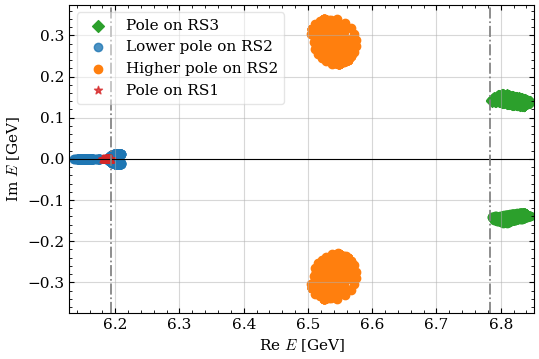

In [38]:
let lower = polesdf_2c[2], higher = polesdf_2c[real.(polesdf_2c.pole_rs2_high) .>6.25, 3], pole3, pole1
    pole1 = polesdf_2c[(real.(polesdf_2c.pole_rs1)) .>0, 1]
    pole3 = polesdf_2c[4]
    PyPlot.subplots(figsize=(6,4))
    PyPlot.axhline([0], color=:k, lw=0.8)
    PyPlot.scatter(real.(pole3), imag.(pole3), color=:C2, label="Pole on RS3", marker="D" )   
    PyPlot.scatter(real.(pole3), -imag.(pole3), color=:C2  )
    PyPlot.scatter(real.(lower), imag.(lower), color=:C0, label="Lower pole on RS2", alpha=0.8 )
    PyPlot.scatter(real.(lower), -imag.(lower), color=:C0, alpha=0.8 )
    PyPlot.scatter(real.(higher), imag.(higher), color=:C1, label="Higher pole on RS2"  )   
    PyPlot.scatter(real.(higher), -imag.(higher), color=:C1  )
    PyPlot.scatter(real.(pole1), imag.(pole1), color=:C3, label="Pole on RS1", alpha=0.8, marker="*" )
    PyPlot.axvline(2*mjψ, c = "gray", ls = "-.") # , label=L"2m_{J/\psi}"
    PyPlot.axvline(mjψ+mψp, c = "gray", ls = "-.") 
    PyPlot.xlabel("Re "*L"E"*" [GeV]"); PyPlot.ylabel("Im "*L"E"*" [GeV]")
    PyPlot.legend(framealpha = 0.5); nothing
end
# PyPlot.savefig("poles_2c.pdf")

In [53]:
# invairant mass distribution, min and max
function dist_minmax(df::DataFrame, fitfun, w)
        m = size(df)[1]
        dist = Vector{Float64}(undef, m)
        @inbounds @simd for i = 1:m      
        dist[i] = fitfun(w, Vector(df[i, 2:end]))
        end
        return [extrema(dist)...]
end

function plt_best_band(df::DataFrame, fitfun; withdata=true, 
        xlab=L"M_{J/\psi\, J/\psi}"*" [GeV]", ylab="Events / (28 MeV)")
    
    dist_extrema(w) = dist_minmax(df, fitfun, w)  
    
    n = 500; 
    wv = withdata ? LinRange(6.194, 9.2, n) : LinRange(mjψ+mψp+0.000001, 9.2, n) 
    best = zeros(Float64, n); 
    paras = Array(df[1, 2:end])
    @simd for i = 1:n
        @inbounds best[i] = fitfun(wv[i], paras)
    end
    
    yv = permutedims(reduce(hcat, dist_extrema.(wv))) 
    PyPlot.subplots(figsize=(6,4))
    PyPlot.fill_between( wv,  yv[:,1], yv[:,2], alpha = 0.5, facecolor = "C1" )
    
    if withdata 
        data = data_full;
        PyPlot.errorbar(data.x, data.y, data.err, c="b", fmt = "o", alpha=0.8, label="LHCb data" )
        PyPlot.plot(wv, best, "r-", lw=1.35, label = "2-channel fit")
        PyPlot.plot(wv, dpsmodel.(wv, Ref(args(dpsfit_poly))), label="DPS", ":" ) 
        PyPlot.axvline(mjψ+mψp, c = "gray", ls = "-.") #, label=L"m_{J/\psi} + m_{\psi(2S)}") 
        PyPlot.axvspan(2*mjψ, data.x[ndata]+0.01, color=:C2, alpha=0.2, label="Fit range")
        PyPlot.xlabel(xlab); PyPlot.ylabel(ylab)
        PyPlot.xlim(6.15, 9); PyPlot.ylim(0, 190); 
    else
        PyPlot.plot(wv, best, "r-", lw=1.35, label = "2-channel fit" )
        PyPlot.xlabel(xlab); PyPlot.ylabel(ylab); 
        PyPlot.xlim(6.15, 9); PyPlot.ylim(0, 85); 
    end
    
    PyPlot.legend(framealpha = 0.5);
    nothing  
end

plt_best_band (generic function with 1 method)

In [54]:
function dist_psipsip(w, par)
    if typeof(par) <: AbstractArray
        npar = length(par)
        t11, t21, t22 = T(w, view(par, 1:5))
        α, β, r, bg, ct = view(par, (npar-4):npar)
    elseif typeof(par) <: Tuple
        a1, a2, c, b1, b2, α, β, r, bg, ct = par
        t11, t21, t22 = T(w, par)
    else
        error("typeof(par) = $(typeof(par)); it has to be either an Array or a Tuple.")
    end
    
    s = w^2
    g1 = Gdr(w, mjψ, mjψ)
    g2 = Gdr(w, mψp, mjψ)

    amp = α*exp(-β*s) * (ct + g1*t21 + r*g2*t22) 
    
    return phsp(w,mjψ,mψp) * (abs2(amp) + bg)
end

dist_psipsip (generic function with 1 method)

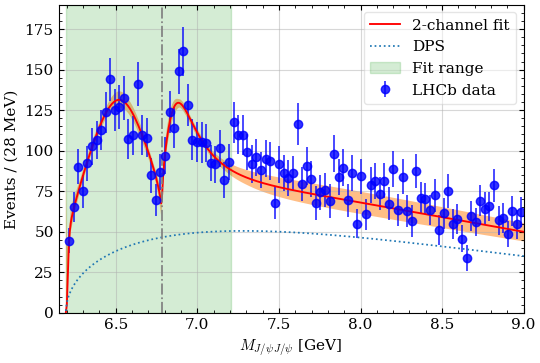

In [55]:
dist_minmax(parametersets_2c, dist, 7)
plt_best_band(parametersets_2c, dist)
# PyPlot.savefig("bestfit_2c.pdf")

* Prediction of the $J/\psi\psi(2S)$ distribution

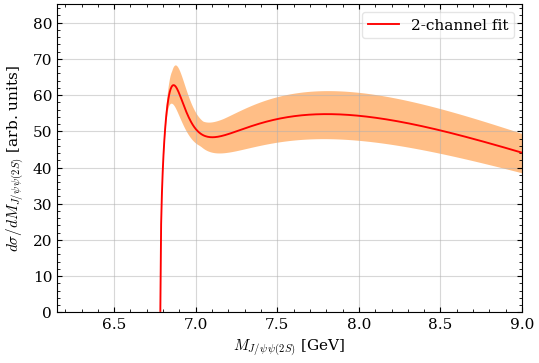

In [56]:
plt_best_band(parametersets_2c, dist_psipsip, withdata=false, 
    xlab=L"M_{J/\psi\, \psi(2S)}"*" [GeV]", ylab=L"d\sigma/dM_{J/\psi\, \psi(2S)}"*" [arb. units]")

## Fits with three channels: $J/\psi J/\psi, \psi' J/\psi, \psi''J/\psi$

Now we consider three channels with only constant contact terms. 

* The observation is based on the fact that the dip and peak are close to the $J/\psi \psi'$ and $J/\psi \psi(3770)$ thresholds, respectively.

* The most general contact-term matrix is a symmetric matrix and has 6 parameters.

In [7]:
using LinearAlgebra, StaticArrays

In [8]:
# preallocating memory to achieve allocation-free code for the T matrix
const cmatrix3 = zeros(ComplexF64, 3, 3);
const vmatrix3 = zeros(Float64, 3, 3);

In [9]:
# construct V and G matrices using StaticArrays to achieve allocation-free code
function vmatrix!(vm, par)
    vm[1,1], vm[2,1], vm[3,1], vm[2,2], vm[3,2], vm[3,3] = par
    vm[1,1] *= 4mjψ^2
    vm[2,1] *= 4mjψ*sqrt(mjψ*mψp)
    vm[3,1] *= 4mjψ*sqrt(mjψ*mψ3770)
    vm[2,2] *= 4mjψ*mψp
    vm[2,3] *= 4mjψ*sqrt(mψp*mψ3770)
    vm[3,3] *= 4mjψ*mψ3770
    vm[1,2] = vm[2,1]; vm[1,3] = vm[3,1]; vm[2,3] = vm[3,2]
    return SMatrix{3,3}(vm)
end

function gmatrix!(gm, w; rs=111)

    gm[1,1] = Gdr(w, mjψ, mjψ)
    gm[2,2] = Gdr(w, mψp, mjψ)
    gm[3,3] = Gdr(w, mψ3770, mjψ)
    
    if rs == 111
        nothing
    elseif rs == 211
        gm[1,1] += 2im *ρ(w,mjψ,mjψ)
    elseif rs == 221
        gm[1,1] += 2im *ρ(w,mjψ,mjψ)
        gm[2,2] += 2im *ρ(w,mψp,mjψ)
    elseif rs == 222
        gm[1,1] += 2im *ρ(w,mjψ,mjψ)
        gm[2,2] += 2im *ρ(w,mψp,mjψ)
        gm[3,3] += 2im *ρ(w,mψ3770,mjψ)
    else
        error("rs should be 111, 211, 221 or 222.")
    end
    return SMatrix{3,3}(gm)
end

function tmatrix(w, par; rs=111)
    vm = vmatrix!(vmatrix3, par)
    gm = gmatrix!(cmatrix3, w, rs=rs)
    return vm * inv(I - gm * vm)
end

function detden(w, par; rs=111)
    vm = vmatrix!(vmatrix3, par)
    gm = gmatrix!(cmatrix3, w, rs=rs)
    return det(I - gm * vm)
end

detden (generic function with 1 method)

In [62]:
# for searching poles in the 3-channel case
function tdet_3c!(F, x, par, rs)
    w = x[1] + 1im*x[2]
    den = detden(w, par, rs=rs)   
    F[1] = real(den)
    F[2] = imag(den)
end

function tdet_3c!(F, x, fit::AbstractFit, rs)
    w = x[1] + 1im*x[2]
    par = args(fit) 
    tdet_3c!(F, x, par, rs)
end

# search for poles with parameters from fit in Riemann sheets 111, 211, 221, 222
function poles_3c(pars; init_val = [6.85, 0.1])
    _cont = Vector{ComplexF64}(undef, 4)
    _sheets = (111, 211, 221, 222)
    for i = eachindex(_sheets)
        sol = nlsolve((F,x) -> tdet_3c!(F,x, pars, _sheets[i]), init_val)
        _cont[i] = sol.residual_norm < 1e-8 ? complex(sol.zero[1], sol.zero[2]) : NaN+1im*NaN
    end
    return  DataFrame([1:4, _cont], [:sheet, :pole])
end

function poles_3c(whichfit::S; kwds...) where S <: Union{Symbol, Expr}
    pars  = args(eval(whichfit))
    println("Pole positions for $whichfit:")
    return  poles_3c(pars; kwds...)
end

poles_3c(fit::ArrayFit; kwds...) = poles_3c(args(fit); kwds...)

function plt_tmatrix_3c(whichfit::S; zup=100) where S <: Union{Symbol, Expr}
    fit = eval(whichfit)
    pars = args(fit)
    tij(x,y,rs) = tmatrix(x + 1im*y, pars, rs=rs)[2]
    
    n = 500
    x = LinRange(6.15, 7.1, n)
    y = LinRange(-0.35, 0.35, n)
    
    gr()    
    plt_rs(rs) = plot(x, y, (a,b)->abs(tij(a,b,rs)), zlim=(0,zup), st=[:surface, :contourf], c=:GnBu_3, 
        camera=(30,30), title="Riemann sheet $rs", legend=false, layout=2, titlefont = (10, "times")) 
    
    p11 = plt_rs(111); p2 = plt_rs(211); p3 = plt_rs(221); p4 = plt_rs(222)
    
    title = plot(title = "Amplitude of J/ψ ψ' → J/ψ J/ψ for $whichfit", titlefont = (12, "serif"), 
            grid = false, showaxis = false, bottom_margin = -60Plots.px)
    plot(title, p11, p2, p3, p4, size=(880,450), layout = @layout([A{0.1h}; [B C; D E]]))
    
end

function plt_tmatrix_3c(pars; zup=100) 
    tij(x,y,rs) = tmatrix(x + 1im*y, pars, rs=rs)[2]
    
    n = 500; x = LinRange(6.15, 7.1, n); y = LinRange(-0.35, 0.35, n)
    
    gr()    
    plt_rs(rs) = plot(x, y, (a,b)->abs(tij(a,b,rs)), zlim=(0,zup), st=[:surface, :contourf], c=:GnBu_3, 
        camera=(30,30), title="Riemann sheet $rs", legend=false, layout=2, titlefont = (10, "times")) 
    
    p11 = plt_rs(111); p2 = plt_rs(211); p3 = plt_rs(221); p4 = plt_rs(222)
    
    title = plot(title = "Amplitude of J/ψ ψ' → J/ψ J/ψ", titlefont = (12, "serif"), 
            grid = false, showaxis = false, bottom_margin = -60Plots.px)
    plot(title, p11, p2, p3, p4, size=(880,450), layout = @layout([A{0.1h}; [B C; D E]]))
end


plt_tmatrix_3c (generic function with 2 methods)

In [63]:
# distribution for three-channel model
function dist3(w, par, prod = (α,β,s)->α*exp(-β*s))
    if typeof(par) <: AbstractArray
        npar = length(par)
        t11, t21, t31 = @view tmatrix(w, view(par, 1:6))[1:3]
        α, β, r1, r2, bg, ct = view(par, (npar-5):npar)
    elseif typeof(par) <: Tuple
        a11, a12, a13, a22, a23, a33, α, β, r1, r2, bg, ct = par
        t11, t21 , t31 = tmatrix(w, par)
    else
        error("typeof(par) = $(typeof(par)); it has to be either an Array or a Tuple.")
    end
    
    s = w^2
    
    g1 = Gdr(w, mjψ, mjψ)
    g2 = Gdr(w, mψp, mjψ)
    g3 = Gdr(w, mψ3770, mjψ)
    
    amp = prod(α,β,s) * (ct + g1*t11 + r1*g2*t21 + r2*g3*t31) 
    
    return phsp(w,mjψ,mjψ) * (abs2(amp) + bg)
end

dist3 (generic function with 2 methods)

### Fits with 3 channels

In [62]:
@time search_init_rand(dist3, data_full[1:ndata], nrand=200, dof=ndata-8, onlynan=true, nchannels=3)

 24.825447 seconds (37.09 M allocations: 1.638 GiB, 4.28% gc time)


2×3 DataFrame. Omitted printing of 1 columns
│ Row │ chisq  │ lecs_init                                                       │
│     │ Real   │ Tuple                                                           │
├─────┼────────┼─────────────────────────────────────────────────────────────────┤
│ 1   │ 1.1834 │ (7.0, 24.9, -31.6, -4.3, 38.3, -6.4, 433, 0.012336, 1, 1, 0, 1) │
│ 2   │ 1.2197 │ (18.3, 4.3, 24.3, -3.6, -8.4, -1.3, 433, 0.012336, 1, 1, 0, 1)  │

In [22]:
# @time df_initval_3c_nan20000 = search_init_rand(dist3, data_full[1:ndata], nrand=20000, dof=ndata-8, onlynan=true, nchannels=3)

3094.331759 seconds (3.30 G allocations: 143.520 GiB, 2.49% gc time)


60×3 DataFrame. Omitted printing of 2 columns
│ Row │ chisq  │
│     │ Real   │
├─────┼────────┤
│ 1   │ 0.8773 │
│ 2   │ 0.8782 │
│ 3   │ 0.9096 │
│ 4   │ 0.9522 │
│ 5   │ 0.9611 │
│ 6   │ 0.981  │
│ 7   │ 0.9915 │
│ 8   │ 0.9917 │
│ 9   │ 0.9958 │
│ 10  │ 0.9963 │
⋮
│ 50  │ 1.2301 │
│ 51  │ 1.2313 │
│ 52  │ 1.2323 │
│ 53  │ 1.2341 │
│ 54  │ 1.2348 │
│ 55  │ 1.2367 │
│ 56  │ 1.2377 │
│ 57  │ 1.238  │
│ 58  │ 1.2395 │
│ 59  │ 1.2448 │
│ 60  │ 1.2469 │

* Again with 20000 random initial values, we get many fits
* Choose those with small $\chi^2$ and without causality-violating pole on the 1st sheet
* Most of the fits have very narrow spikes, which should be unphysical

In [64]:
# CSV.write("data/df_initval_3c_nan20000.csv", df_initval_3c_nan20000)
df_initval_3c_nan20000 = read_file("data/df_initval_3c_nan20000.csv");

In [65]:
nfits = nrow(df_initval_3c_nan20000)
fits_3c = Vector(undef, nfits)
@time for i in 1:nfits
    fits_3c[i] = model_fit(dist3, data_full[1:ndata], df_initval_3c_nan20000.lecs_init[i], 
                name=parname_3c, fix_r1=true, fix_r2=true, fix_beta=true, fix_bg=true)
    fits_3c[i].strategy = 2;
    makefit(fits_3c[i], dof=ndata-8, printout=false)
end

  9.960732 seconds (13.31 M allocations: 616.912 MiB, 2.30% gc time)


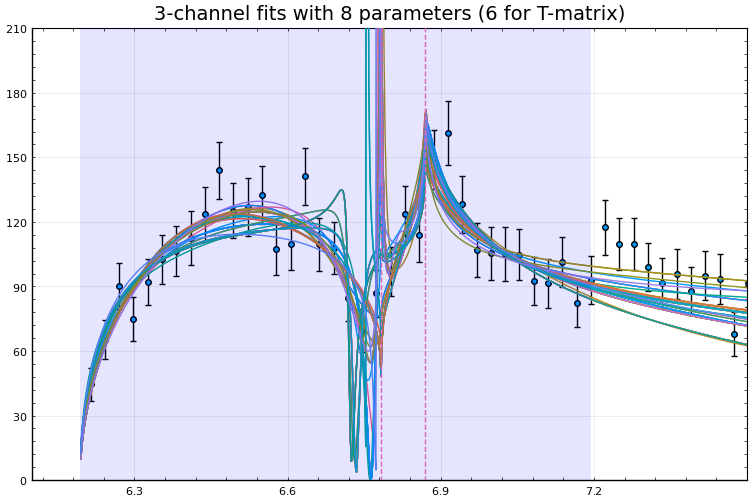

In [71]:
pyplot(size=(750,500))
@plt_data data_full xlim=(6.1,7.5) ylim=(0, 210) label="Data"
for i = 1:nfits
    plot!(6.195:0.002:9.2, x->dist3(x, args(fits_3c[i])), label="fits_3c[$i]")
end
vspan!([2*mjψ, data_full.:x[ndata]], alpha=0.1, label="Fit range", c="blue")
vline!([mjψ+mψp, mjψ+mψ3770], line=:dash, label="thresholds")
plot!(title="3-channel fits with 8 parameters (6 for T-matrix)", legend= :none)

In [72]:
goodsets_3c = reasonable_pars(dist3, fits_3c, nchannels=3)

(13, 14, 16, 27, 29, 30, 31, 32, 34, 35, 37, 39, 41, 42, 45, 47, 49, 52, 54, 55)

In [73]:
# these have χ²/dof < 1.1 and don't have unphysical spikes
bestsets_3c = (13, 14, 16);

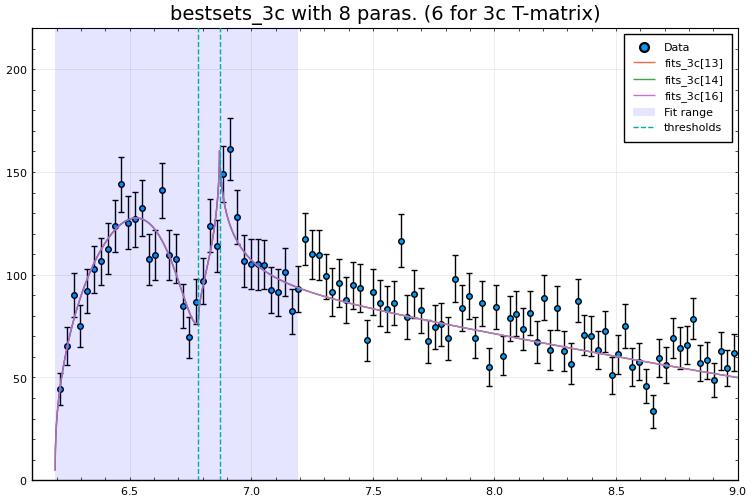

In [75]:
function plt_sets(psets::Symbol)
    sets = eval(psets)
    @plt_data data_full xlim=(6.1,9) ylim=(0, 220) label="Data"
    for i = sets
        plot!(6.1939:0.001:9.2, x->dist3(x, args(fits_3c[i])), label="fits_3c[$i]")
    end
    vspan!([2*mjψ, data_full.:x[ndata]], alpha=0.1, label="Fit range", c="blue")
    vline!([mjψ+mψp, mjψ+mψ3770], line=:dash, label="thresholds")
    plot!(title="$psets with 8 paras. (6 for 3c T-matrix)")
end

pyplot()
p1 = plt_sets(:goodsets_3c); p2 = plt_sets(:bestsets_3c)
# plot(p1, p2, size=(1000, 350))

In [69]:
df_initval_3c_nan20000[collect(bestsets_3c), :]

3×3 DataFrame. Omitted printing of 1 columns
│ Row │ chisq   │ lecs_init                                                         │
│     │ Float64 │ Tuple…                                                            │
├─────┼─────────┼───────────────────────────────────────────────────────────────────┤
│ 1   │ 1.0516  │ (44.5, 47.6, 9.2, 34.7, 43.3, -15.5, 433, 0.012336, 1, 1, 0, 1)   │
│ 2   │ 1.0686  │ (32.7, 24.3, -10.7, 21.4, 10.8, -24.0, 433, 0.012336, 1, 1, 0, 1) │
│ 3   │ 1.0926  │ (33.4, 21.6, -24.0, 14.0, -33.3, 4.6, 433, 0.012336, 1, 1, 0, 1)  │

In [76]:
# after minimization for a few more times, these three sets lead to the same best fit!
do_minos(fits_3c[13])

PyObject MigradResult(fmin=FMin(fval=29.443793671712697, edm=3.9245168077904745e-11, tolerance=0.1, nfcn=152, ncalls=15600, up=1.0, is_valid=True, has_valid_parameters=True, has_accurate_covar=True, has_posdef_covar=True, has_made_posdef_covar=False, hesse_failed=False, has_covariance=True, is_above_max_edm=False, has_reached_call_limit=False, has_parameters_at_limit=False), params=[Param(number=0, name='a11', value=7.8080950846751636, error=2.20994322325181, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=1, name='a12', value=15.878616818652532, error=3.9760297228814556, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=2, name='a13', value=0.8927455138278779, error=2.2798264919753883, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=3, name='a22', value=25.77119665821172, error=7.08418883865101, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=4, name='a23', value=-117.72575794288365, error=194.470338410563, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=5, name='a33', value=-2.510419153939198, error=1.2751248937445379, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=6, name='alpha', value=143.9818143633033, error=37.344997504455286, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=7, name='beta', value=0.012336, error=0.00012336, is_const=False, is_fixed=True, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=8, name='r1', value=1.0, error=0.01, is_const=False, is_fixed=True, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=9, name='r2', value=1.0, error=0.01, is_const=False, is_fixed=True, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=10, name='bg', value=0.0, error=0.1, is_const=False, is_fixed=True, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=11, name='ct', value=-0.7047561991994133, error=0.4187948917359585, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None)])

In [77]:
# it turns out that they can be tuned to a better fit! found during error analysis
fit_3c_best = model_fit(dist3, data_full[1:ndata], (7.41,13.09,1.17,17.75,-40.37,-2.874,210.836,0.012336,1.0,1.0,0.0,-0.234665); 
    name = parname_3c, fix_r1=true, fix_r2=true, fix_beta=true, fix_bg=true)
fit_3c_best.strategy = 2; 
makefit(fit_3c_best, dof=ndata-8)

χ²/dof = 0.9714772376418317


PyObject MigradResult(fmin=FMin(fval=27.20136233136637, edm=2.2583781755774795e-11, tolerance=0.1, nfcn=141, ncalls=803, up=1.0, is_valid=True, has_valid_parameters=True, has_accurate_covar=True, has_posdef_covar=True, has_made_posdef_covar=False, hesse_failed=False, has_covariance=True, is_above_max_edm=False, has_reached_call_limit=False, has_parameters_at_limit=False), params=[Param(number=0, name='a11', value=6.034105927592854, error=1.8201650331582426, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=1, name='a12', value=10.296388910252606, error=3.00719451521143, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=2, name='a13', value=-0.2448935301930983, error=1.5947637222232682, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=3, name='a22', value=13.188601202281657, error=4.717644595756847, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=4, name='a23', value=-119.35370238399602, error=89.44252869157224, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=5, name='a33', value=-2.308512744779199, error=1.3549755679666722, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=6, name='alpha', value=246.2904432736839, error=56.16543779083302, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=7, name='beta', value=0.012336, error=0.00012336, is_const=False, is_fixed=True, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=8, name='r1', value=1.0, error=0.01, is_const=False, is_fixed=True, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=9, name='r2', value=1.0, error=0.01, is_const=False, is_fixed=True, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=10, name='bg', value=0.0, error=0.1, is_const=False, is_fixed=True, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=11, name='ct', value=-0.11522106129098193, error=0.20851972244289138, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None)])

In [78]:
do_minos(fit_3c_best)

PyObject MigradResult(fmin=FMin(fval=27.201362331351287, edm=6.670451023181486e-12, tolerance=0.1, nfcn=148, ncalls=15668, up=1.0, is_valid=True, has_valid_parameters=True, has_accurate_covar=True, has_posdef_covar=True, has_made_posdef_covar=False, hesse_failed=False, has_covariance=True, is_above_max_edm=False, has_reached_call_limit=False, has_parameters_at_limit=False), params=[Param(number=0, name='a11', value=6.034109389456529, error=1.8201807168194613, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=1, name='a12', value=10.296396520427733, error=3.0072192495757815, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=2, name='a13', value=-0.24488760635936946, error=1.5947670789146309, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=3, name='a22', value=13.188616912710355, error=4.71767071378023, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=4, name='a23', value=-119.35337013640473, error=89.44275786632366, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=5, name='a33', value=-2.308517627838097, error=1.3549700265630513, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=6, name='alpha', value=246.2903340143385, error=56.1657198962512, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=7, name='beta', value=0.012336, error=0.00012336, is_const=False, is_fixed=True, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=8, name='r1', value=1.0, error=0.01, is_const=False, is_fixed=True, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=9, name='r2', value=1.0, error=0.01, is_const=False, is_fixed=True, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=10, name='bg', value=0.0, error=0.1, is_const=False, is_fixed=True, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=11, name='ct', value=-0.11522138384850197, error=0.20852092492021723, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None)])

* Pick out only those behaving well
* Ony two fits left with $\chi^2/$dof$<1.1$; Fit 1: $\chi^2/$dof$=0.97$, Fit 2: $\chi^2/$dof$=1.05$
* Differ by the value of $a_{22}$

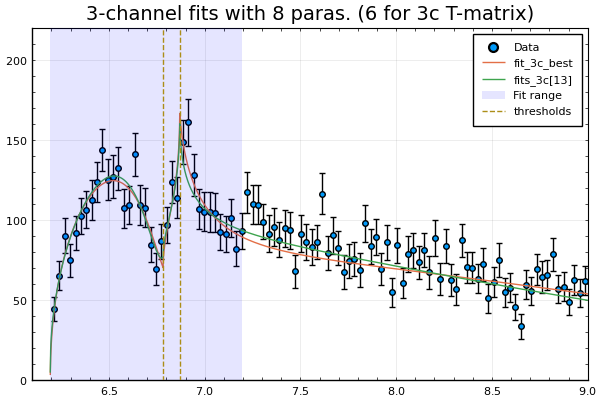

In [79]:
pyplot(size=(600,400))
@plt_data data_full xlim=(6.1,9) ylim=(0, 220) label="Data" 
plot!(6.1939:0.001:9.2, x->dist3(x, args(fit_3c_best)), label="fit_3c_best")
plot!(6.1939:0.001:9.2, x->dist3(x, args(fits_3c[13])), label="fits_3c[13]")
vspan!([2*mjψ, data_full.:x[ndata]], alpha=0.1, label="Fit range", c="blue")
vline!([mjψ+mψp, mjψ+mψ3770], line=:dash, label="thresholds")
plot!(title="3-channel fits with 8 paras. (6 for 3c T-matrix)")

### Error analysis

* generating more than 1000 parameter sets within $1\sigma$

In [80]:
function poles_error_analysis_3c(parsdf::DataFrame)
    _df = DataFrame(pole_rs111=Complex[], pole_rs211_low=Complex[], 
            pole_rs211_high = Complex[], pole_rs221 = Complex[], pole_rs222 = Complex[]) # 
    _cont = Vector{ComplexF64}(undef, 5)
    for dfrow in eachrow(parsdf)
        _sheets = (111, 211)
        for i = eachindex(_sheets) # pole in the 111 and 211 sheets with a low initial value
            sol = nlsolve((F,x) -> tdet_3c!(F,x, Vector(dfrow[2:end]), _sheets[i]), [6.19, 0.001])
            _cont[i] = sol.residual_norm < 1e-8 ? complex(sol.zero[1], sol.zero[2]) : NaN+1im*NaN
        end
        _sheets = (211, 221, 222)
        for i = eachindex(_sheets) # pole in the 221 and 222 sheets with a high initial value
            sol = nlsolve((F,x) -> tdet_3c!(F,x, Vector(dfrow[2:end]), _sheets[i]), [6.9, 0.3])
            _cont[i+2] = sol.residual_norm < 1e-8 ? complex(sol.zero[1], sol.zero[2]) : NaN+1im*NaN
        end
        push!(_df, _cont)
    end
    return _df
end

poles_error_analysis_3c (generic function with 1 method)

In [81]:
chisq_3c(par) = chisq(dist3, data_full[1:ndata], par)

chisq_3c (generic function with 1 method)

In [82]:
fit_ea_3c = Minuit(chisq_3c, ((7.41,13.09,1.17,17.75,-40.37,-2.874,210.836,0.012336,1.0,1.0,0.0,-0.234665)); 
    name = parname_3c, fix_r1=true, fix_r2=true, fix_beta=true, fix_bg=true)
fit_ea_3c.strategy = 2; #(7.41,13.09,1.17,17.75,-40.37,-2.874,210.836,0.012336,1.0,1.0,0.0,-0.234665)
makefit(fit_ea_3c, dof=ndata-8);

χ²/dof = 0.9714772376418317


In [83]:
hesse(fit_3c_best); migrad(fit_3c_best); migrad(fit_3c_best);
minos(fit_3c_best)

PyObject MErrors([('a11', MError(name='a11', is_valid=True, lower=-1.5907343837422112, upper=2.21154936430907, lower_valid=True, upper_valid=True, at_lower_limit=False, at_upper_limit=False, at_lower_max_fcn=False, at_upper_max_fcn=False, lower_new_min=False, upper_new_min=False, nfcn=1517, min=6.034109408420294)), ('a12', MError(name='a12', is_valid=True, lower=-2.772589503997055, upper=3.3941318157103697, lower_valid=True, upper_valid=True, at_lower_limit=False, at_upper_limit=False, at_lower_max_fcn=False, at_upper_max_fcn=False, lower_new_min=False, upper_new_min=False, nfcn=1120, min=10.296396560800874)), ('a13', MError(name='a13', is_valid=True, lower=-1.2937441363714335, upper=1.854895787488534, lower_valid=True, upper_valid=True, at_lower_limit=False, at_upper_limit=False, at_lower_max_fcn=False, at_upper_max_fcn=False, lower_new_min=False, upper_new_min=False, nfcn=1416, min=-0.24488757556506163)), ('a22', MError(name='a22', is_valid=True, lower=-4.411018942501913, upper=4.916514372293452, lower_valid=True, upper_valid=True, at_lower_limit=False, at_upper_limit=False, at_lower_max_fcn=False, at_upper_max_fcn=False, lower_new_min=False, upper_new_min=False, nfcn=757, min=13.18861699504486)), ('a23', MError(name='a23', is_valid=True, lower=-61.81544269722762, upper=113.15693940969197, lower_valid=True, upper_valid=True, at_lower_limit=False, at_upper_limit=False, at_lower_max_fcn=False, at_upper_max_fcn=False, lower_new_min=False, upper_new_min=False, nfcn=1567, min=-119.35336840366465)), ('a33', MError(name='a33', is_valid=True, lower=-1.0606396646478156, upper=1.531128674128349, lower_valid=True, upper_valid=True, at_lower_limit=False, at_upper_limit=False, at_lower_max_fcn=False, at_upper_max_fcn=False, lower_new_min=False, upper_new_min=False, nfcn=1042, min=-2.308517653045591)), ('alpha', MError(name='alpha', is_valid=False, lower=-56.165619457526326, upper=74.36114150247585, lower_valid=False, upper_valid=True, at_lower_limit=False, at_upper_limit=False, at_lower_max_fcn=False, at_upper_max_fcn=False, lower_new_min=False, upper_new_min=False, nfcn=3443, min=246.29033348592674)), ('ct', MError(name='ct', is_valid=True, lower=-0.2225936383674693, upper=0.21075069805885172, lower_valid=True, upper_valid=True, at_lower_limit=False, at_upper_limit=False, at_lower_max_fcn=False, at_upper_max_fcn=False, lower_new_min=False, upper_new_min=False, nfcn=815, min=-0.11522138535088841))])

In [84]:
makefit(fit_3c_best, dof=ndata-8)

χ²/dof = 0.971477226119686


PyObject MigradResult(fmin=FMin(fval=27.20136233135121, edm=6.673295715064044e-12, tolerance=0.1, nfcn=133, ncalls=28153, up=1.0, is_valid=True, has_valid_parameters=True, has_accurate_covar=True, has_posdef_covar=True, has_made_posdef_covar=False, hesse_failed=False, has_covariance=True, is_above_max_edm=False, has_reached_call_limit=False, has_parameters_at_limit=False), params=[Param(number=0, name='a11', value=6.034109408420294, error=1.820177554175706, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=1, name='a12', value=10.296396560800874, error=3.0072125699233836, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=2, name='a13', value=-0.24488757556506163, error=1.5947631783092668, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=3, name='a22', value=13.18861699504486, error=4.717658389072275, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=4, name='a23', value=-119.35336840366465, error=89.44254738252168, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=5, name='a33', value=-2.308517653045591, error=1.3549672103048571, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=6, name='alpha', value=246.29033348592674, error=56.1656087717334, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=7, name='beta', value=0.012336, error=0.00012336, is_const=False, is_fixed=True, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=8, name='r1', value=1.0, error=0.01, is_const=False, is_fixed=True, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=9, name='r2', value=1.0, error=0.01, is_const=False, is_fixed=True, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=10, name='bg', value=0.0, error=0.1, is_const=False, is_fixed=True, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=11, name='ct', value=-0.11522138535088841, error=0.20852059400650258, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None)])

In [85]:
# @time parametersets_3c_cont = contour_df(fit_3c_best, chisq_3c, npts=30);
# # try to sample all combinations of free parameters
# parametersets_3c = let df, com, comp, comv, rv, pars
#     pars = (:a11, :a12, :a13, :a22, :a23, :a33, :alpha, :ct)
#     rv= ((4.3,8.3), (7.4,13.8),  (-1.6,1.8), (8,19), (-190,0), (-3.5, -0.7), (180, 330), (-0.35, 0.1) )
    
#     comp = combinations(pars, 2); comv = combinations(rv, 2)
#     com = Vector{Any}(undef, 28)
    
#     for (i, par, val) in zip(1:28, comp, comv)
#         com[i]= contour_df_samples(fit_3c_best, chisq_3c, par, val, nsamples=100)
#     end
    
#     df = vcat(parametersets_3c_cont, com...)
#     df[df.chisq .>= df.chisq[1], :]
# end

# @time parametersets_3c_fit2_cont = contour_df(fit_ea_3c16, chisq_3c, npts=30);
# # try to sample all combinations of free parameters
# parametersets_3c_fit2 = let df, com, comp, comv, rv, pars
#     pars = (:a11, :a12, :a13, :a22, :a23, :a33, :alpha, :ct)
#     rv= ((5.7,11.3), (12.3,19.6), (-1.5,3.3), (-19,39), (-340,80), (-3.6,0.3), (116, 212), (-1.2, -0.1) )
    
#     comp = combinations(pars, 2); comv = combinations(rv, 2)
#     com = Vector{Any}(undef, 28)
    
#     for (i, par, val) in zip(1:28, comp, comv)
#         com[i]= contour_df_samples(fit_ea_3c16, chisq_3c, par, val, nsamples=100)
#     end
    
#     df = vcat(parametersets_3c_fit2_cont, com...)
#     df[df.chisq .>= df.chisq[1], :]
# end

# CSV.write("data/parametersets_3c.csv", parametersets_3c)
# CSV.write("data/parametersets_3c_fit2.csv", parametersets_3c_fit2)

parametersets_3c = DataFrame!(CSV.File("data/parametersets_3c.csv"))
parametersets_3c_fit2 = DataFrame!(CSV.File("data/parametersets_3c_fit2.csv"))

1045×13 DataFrame
│ Row  │ chisq   │ a11     │ a12     │ a13       │ a22     │ a23      │ a33       │ alpha   │ beta     │ r1      │ r2      │ bg      │ ct        │
│      │ Float64 │ Float64 │ Float64 │ Float64   │ Float64 │ Float64  │ Float64   │ Float64 │ Float64  │ Float64 │ Float64 │ Float64 │ Float64   │
├──────┼─────────┼─────────┼─────────┼───────────┼─────────┼──────────┼───────────┼─────────┼──────────┼─────────┼─────────┼─────────┼───────────┤
│ 1    │ 29.4438 │ 7.8081  │ 15.8786 │ 0.892733  │ 25.7712 │ -117.727 │ -2.51041  │ 143.982 │ 0.012336 │ 1.0     │ 1.0     │ 0.0     │ -0.704757 │
│ 2    │ 30.4439 │ 5.84    │ 12.9141 │ 0.597523  │ 21.4464 │ -128.234 │ -2.57643  │ 132.529 │ 0.012336 │ 1.0     │ 1.0     │ 0.0     │ -0.878857 │
│ 3    │ 30.4438 │ 6.24327 │ 12.3671 │ 0.989642  │ 20.0518 │ -85.0853 │ -2.98444  │ 155.249 │ 0.012336 │ 1.0     │ 1.0     │ 0.0     │ -0.623746 │
│ 4    │ 30.4438 │ 8.41384 │ 16.8334 │ 3.18945   │ 27.7853 │ 69.0778  │ -2.96629  │ 157.893 │ 0.012336 │ 1.0     │ 1.0     │ 0.0     │ -0.566607 │
│ 5    │ 30.4858 │ 7.12563 │ 13.545  │ 2.11655   │ 21.8323 │ 1.3457   │ -3.49481  │ 167.184 │ 0.012336 │ 1.0     │ 1.0     │ 0.0     │ -0.507315 │
│ 6    │ 30.4438 │ 6.51523 │ 12.4616 │ 0.837913  │ 19.9055 │ -97.3117 │ -2.93526  │ 160.814 │ 0.012336 │ 1.0     │ 1.0     │ 0.0     │ -0.564697 │
│ 7    │ 30.4438 │ 11.0288 │ 19.3216 │ 0.681573  │ 29.5814 │ -140.044 │ -2.34912  │ 176.086 │ 0.012336 │ 1.0     │ 1.0     │ 0.0     │ -0.371151 │
│ 8    │ 30.4438 │ 7.90226 │ 18.1882 │ 1.23287   │ 31.5733 │ -93.4877 │ -2.47016  │ 127.197 │ 0.012336 │ 1.0     │ 1.0     │ 0.0     │ -0.917833 │
│ 9    │ 30.444  │ 6.35254 │ 14.8483 │ 0.884058  │ 25.4233 │ -112.201 │ -2.54666  │ 126.272 │ 0.012336 │ 1.0     │ 1.0     │ 0.0     │ -0.953711 │
│ 10   │ 30.4447 │ 5.84    │ 12.9109 │ 0.644698  │ 21.4627 │ -124.066 │ -2.61066  │ 132.87  │ 0.012336 │ 1.0     │ 1.0     │ 0.0     │ -0.874978 │
⋮
│ 1035 │ 30.1428 │ 7.01945 │ 14.3597 │ 1.93361   │ 23.6415 │ -22.4895 │ -3.28485  │ 147.574 │ 0.012336 │ 1.0     │ 1.0     │ 0.0     │ -0.688889 │
│ 1036 │ 29.6212 │ 8.36016 │ 15.7825 │ 1.09505   │ 25.0159 │ -97.0707 │ -2.65455  │ 163.026 │ 0.012336 │ 1.0     │ 1.0     │ 0.0     │ -0.511111 │
│ 1037 │ 30.1692 │ 7.72576 │ 16.3843 │ -1.09139  │ 25.9464 │ -285.461 │ -0.960606 │ 125.424 │ 0.012336 │ 1.0     │ 1.0     │ 0.0     │ -0.922222 │
│ 1038 │ 30.024  │ 8.10488 │ 16.6882 │ -0.953666 │ 26.2507 │ -275.135 │ -1.07879  │ 131.524 │ 0.012336 │ 1.0     │ 1.0     │ 0.0     │ -0.833333 │
│ 1039 │ 29.9566 │ 9.06078 │ 16.6916 │ 0.0944608 │ 25.8048 │ -181.845 │ -2.02424  │ 162.109 │ 0.012336 │ 1.0     │ 1.0     │ 0.0     │ -0.5      │
│ 1040 │ 30.1313 │ 8.01313 │ 16.6437 │ -1.11974  │ 26.1534 │ -288.535 │ -0.921212 │ 129.019 │ 0.012336 │ 1.0     │ 1.0     │ 0.0     │ -0.866667 │
│ 1041 │ 29.4438 │ 7.8081  │ 15.8786 │ 0.892733  │ 25.7712 │ -117.727 │ -2.51041  │ 143.982 │ 0.012336 │ 1.0     │ 1.0     │ 0.0     │ -0.704757 │
│ 1042 │ 30.041  │ 9.04743 │ 15.8427 │ 1.42841   │ 24.5578 │ -62.5709 │ -2.9081   │ 188.727 │ 0.012336 │ 1.0     │ 1.0     │ 0.0     │ -0.311111 │
│ 1043 │ 29.9406 │ 6.93841 │ 13.6783 │ 1.58417   │ 22.2735 │ -40.7709 │ -3.07656  │ 160.606 │ 0.012336 │ 1.0     │ 1.0     │ 0.0     │ -0.566667 │
│ 1044 │ 30.2964 │ 9.54278 │ 16.198  │ 1.41064   │ 24.8177 │ -61.4525 │ -2.93383  │ 200.364 │ 0.012336 │ 1.0     │ 1.0     │ 0.0     │ -0.233333 │
│ 1045 │ 30.3138 │ 6.7495  │ 13.0228 │ 1.73036   │ 21.1423 │ -20.831  │ -3.23266  │ 169.333 │ 0.012336 │ 1.0     │ 1.0     │ 0.0     │ -0.5      │

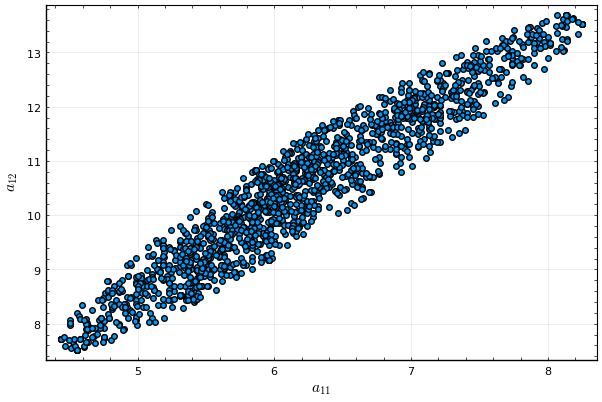

In [87]:
pyplot()
scatter(parametersets_3c.a11, parametersets_3c.a12, legend=nothing, xlab=L"a_{11}", ylab=L"a_{12}")

In [88]:
fit_ea_3c_fit2 = Minuit(chisq_3c, args(fits_3c[13]); 
    name = parname_3c, fix_r1=true, fix_r2=true, fix_beta=true, fix_bg=true)
fit_ea_3c_fit2.strategy = 2;
makefit(fit_ea_3c_fit2, dof=ndata-8)
minos(fit_ea_3c_fit2)

χ²/dof = 1.051564059702585


PyObject MErrors([('a11', MError(name='a11', is_valid=True, lower=-1.968089111875754, upper=3.374268774305909, lower_valid=True, upper_valid=True, at_lower_limit=False, at_upper_limit=False, at_lower_max_fcn=False, at_upper_max_fcn=False, lower_new_min=False, upper_new_min=False, nfcn=1445, min=7.808091779759835)), ('a12', MError(name='a12', is_valid=False, lower=-3.5115291711057326, upper=3.573139055118226, lower_valid=True, upper_valid=False, at_lower_limit=False, at_upper_limit=False, at_lower_max_fcn=False, at_upper_max_fcn=False, lower_new_min=False, upper_new_min=False, nfcn=2185, min=15.878610986665073)), ('a13', MError(name='a13', is_valid=True, lower=-2.518915543884978, upper=2.296714590713983, lower_valid=True, upper_valid=True, at_lower_limit=False, at_upper_limit=False, at_lower_max_fcn=False, at_upper_max_fcn=False, lower_new_min=False, upper_new_min=False, nfcn=875, min=0.8927321547828698)), ('a22', MError(name='a22', is_valid=True, lower=-5.865876268807417, upper=11.567911077861966, lower_valid=True, upper_valid=True, at_lower_limit=False, at_upper_limit=False, at_lower_max_fcn=False, at_upper_max_fcn=False, lower_new_min=False, upper_new_min=False, nfcn=1791, min=25.771181604295908)), ('a23', MError(name='a23', is_valid=True, lower=-213.99437124533992, upper=191.4248037742696, lower_valid=True, upper_valid=True, at_lower_limit=False, at_upper_limit=False, at_lower_max_fcn=False, at_upper_max_fcn=False, lower_new_min=False, upper_new_min=False, nfcn=895, min=-117.72690338396983)), ('a33', MError(name='a33', is_valid=True, lower=-0.9844006570025805, upper=2.063760641003732, lower_valid=True, upper_valid=True, at_lower_limit=False, at_upper_limit=False, at_lower_max_fcn=False, at_upper_max_fcn=False, lower_new_min=False, upper_new_min=False, nfcn=1725, min=-2.510412655585753)), ('alpha', MError(name='alpha', is_valid=True, lower=-26.720023735286414, upper=66.85751311843022, lower_valid=True, upper_valid=True, at_lower_limit=False, at_upper_limit=False, at_lower_max_fcn=False, at_upper_max_fcn=False, lower_new_min=False, upper_new_min=False, nfcn=1378, min=143.98173618715248)), ('ct', MError(name='ct', is_valid=True, lower=-0.36378069649388767, upper=0.5192669751176032, lower_valid=True, upper_valid=True, at_lower_limit=False, at_upper_limit=False, at_lower_max_fcn=False, at_upper_max_fcn=False, lower_new_min=False, upper_new_min=False, nfcn=1153, min=-0.7047569963701229))])

In [89]:
# the difference between this fit from fit_3c_best is the range of a22
makefit(fit_ea_3c_fit2)

χ²/dof = 1.051564059702585


PyObject MigradResult(fmin=FMin(fval=29.443793671672324, edm=1.5502382095207623e-13, tolerance=0.1, nfcn=169, ncalls=12538, up=1.0, is_valid=True, has_valid_parameters=True, has_accurate_covar=True, has_posdef_covar=True, has_made_posdef_covar=False, hesse_failed=False, has_covariance=True, is_above_max_edm=False, has_reached_call_limit=False, has_parameters_at_limit=False), params=[Param(number=0, name='a11', value=7.808092015607783, error=2.209946324374853, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=1, name='a12', value=15.878611470545366, error=3.9760278350387046, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=2, name='a13', value=0.8927323066438665, error=2.2798280494094407, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=3, name='a22', value=25.77118247206622, error=7.084183999099478, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=4, name='a23', value=-117.7268925783998, error=194.4703039245981, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=5, name='a33', value=-2.510412694251014, error=1.275130213751425, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=6, name='alpha', value=143.98173651389143, error=37.34491146330261, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=7, name='beta', value=0.012336, error=0.00012336, is_const=False, is_fixed=True, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=8, name='r1', value=1.0, error=0.01, is_const=False, is_fixed=True, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=9, name='r2', value=1.0, error=0.01, is_const=False, is_fixed=True, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=10, name='bg', value=0.0, error=0.1, is_const=False, is_fixed=True, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=11, name='ct', value=-0.7047569903626892, error=0.4187944855490388, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None)])

In [84]:
poles_3c(:fit_ea_3c_fit2, init_val=[7.2, 0.25])

Pole positions for fit_ea_3c_fit2:


4×2 DataFrame
│ Row │ sheet │ pole               │
│     │ Int64 │ Complex{Float64}   │
├─────┼───────┼────────────────────┤
│ 1   │ 1     │ NaN+NaN*im         │
│ 2   │ 2     │ 6.89562+0.179361im │
│ 3   │ 3     │ NaN+NaN*im         │
│ 4   │ 4     │ NaN+NaN*im         │

In [85]:
# from this analysis, we get the upper error of a12 for which MINOS failed to compute, yet turned out to be that given by MINOS
parametersets_3c_fit2.a12[1], extrema(parametersets_3c_fit2.a12) .- parametersets_3c_fit2.a12[1]

(15.878622743234354, (-3.5115400710282643, 3.5808069786028067))

In [88]:
poles_error_analysis_3c(parametersets_3c[1:1,:])

1×5 DataFrame
│ Row │ pole_rs111            │ pole_rs211_low │ pole_rs211_high    │ pole_rs221 │ pole_rs222 │
│     │ Complex               │ Complex        │ Complex            │ Complex    │ Complex    │
├─────┼───────────────────────┼────────────────┼────────────────────┼────────────┼────────────┤
│ 1   │ 6.16257-5.77431e-17im │ NaN+NaN*im     │ 7.04611+0.208724im │ NaN+NaN*im │ NaN+NaN*im │

In [90]:
# polesdf_3c = poles_error_analysis_3c(parametersets_3c)
# CSV.write("data/poles_3c.csv", polesdf_3c)

# polesdf_3c_fit2 = poles_error_analysis_3c(parametersets_3c_fit2)
# CSV.write("data/poles_3c_fit2.csv", polesdf_3c_fit2)

polesdf_3c = read_file("data/poles_3c.csv", cols=(:pole_rs111, :pole_rs211_low, :pole_rs211_high, :pole_rs221, :pole_rs222))
polesdf_3c_fit2 = read_file("data/poles_3c_fit2.csv", cols=(:pole_rs111, :pole_rs211_low, :pole_rs211_high, :pole_rs221, :pole_rs222))

1045×5 DataFrame
│ Row  │ pole_rs111 │ pole_rs211_low        │ pole_rs211_high     │ pole_rs221 │ pole_rs222 │
│      │ Complex…   │ Complex{Float64}      │ Complex{Float64}    │ Complex…   │ Complex…   │
├──────┼────────────┼───────────────────────┼─────────────────────┼────────────┼────────────┤
│ 1    │ NaN+NaN*im │ 6.1888-1.40786e-11im  │ 6.89562+0.17936im   │ NaN+NaN*im │ NaN+NaN*im │
│ 2    │ NaN+NaN*im │ 6.1902+8.46756e-12im  │ 6.85912+0.250782im  │ NaN+NaN*im │ NaN+NaN*im │
│ 3    │ NaN+NaN*im │ 6.19061-6.09632e-11im │ 6.97439+0.41686im   │ NaN+NaN*im │ NaN+NaN*im │
│ 4    │ NaN+NaN*im │ 6.19144-6.7952e-15im  │ 6.87903+0.162829im  │ NaN+NaN*im │ NaN+NaN*im │
│ 5    │ NaN+NaN*im │ 6.19178-3.05799e-13im │ 7.02165+0.371869im  │ NaN+NaN*im │ NaN+NaN*im │
│ 6    │ NaN+NaN*im │ 6.19023+9.37519e-12im │ 7.02474+0.492434im  │ NaN+NaN*im │ NaN+NaN*im │
│ 7    │ NaN+NaN*im │ 6.18259+3.20723e-13im │ 6.93368-0.0318062im │ NaN+NaN*im │ NaN+NaN*im │
│ 8    │ NaN+NaN*im │ 6.19002+3.44716e-12im │ 6.77912+0.13582im   │ NaN+NaN*im │ NaN+NaN*im │
│ 9    │ NaN+NaN*im │ 6.19035-7.63909e-13im │ 6.79655+0.174466im  │ NaN+NaN*im │ NaN+NaN*im │
│ 10   │ NaN+NaN*im │ 6.19028+5.44298e-12im │ 6.85907+0.251284im  │ NaN+NaN*im │ NaN+NaN*im │
⋮
│ 1035 │ NaN+NaN*im │ 6.19147-1.05589e-14im │ 6.91356+0.233248im  │ NaN+NaN*im │ NaN+NaN*im │
│ 1036 │ NaN+NaN*im │ 6.18775+1.40771e-16im │ 7.09333+0.210914im  │ NaN+NaN*im │ NaN+NaN*im │
│ 1037 │ NaN+NaN*im │ 6.18574-1.34275e-14im │ 6.83253+0.146344im  │ NaN+NaN*im │ NaN+NaN*im │
│ 1038 │ NaN+NaN*im │ 6.18462-7.79808e-14im │ 6.85247+0.142227im  │ NaN+NaN*im │ NaN+NaN*im │
│ 1039 │ NaN+NaN*im │ 6.1832-9.70491e-14im  │ 7.4239-0.083601im   │ NaN+NaN*im │ NaN+NaN*im │
│ 1040 │ NaN+NaN*im │ 6.18463-7.52881e-14im │ 6.84419+0.14165im   │ NaN+NaN*im │ NaN+NaN*im │
│ 1041 │ NaN+NaN*im │ 6.1888-1.40786e-11im  │ 6.89562+0.17936im   │ NaN+NaN*im │ NaN+NaN*im │
│ 1042 │ NaN+NaN*im │ 6.18749+1.28125e-16im │ 7.30138+0.501965im  │ NaN+NaN*im │ NaN+NaN*im │
│ 1043 │ NaN+NaN*im │ 6.19076-7.10896e-11im │ 6.96885+0.317694im  │ NaN+NaN*im │ NaN+NaN*im │
│ 1044 │ NaN+NaN*im │ 6.18666-1.66692e-15im │ 7.37796+0.661505im  │ NaN+NaN*im │ NaN+NaN*im │
│ 1045 │ NaN+NaN*im │ 6.19144-8.24432e-15im │ 6.98544+0.389165im  │ NaN+NaN*im │ NaN+NaN*im │

Fit 1:
* one bound state pole on the 1st sheet
* one pole above 7 GeV on the 2nd sheet (remote since this is above the $J/\psi \psi(3770)$ threshold)

In [91]:
polesdf_3c[1,:]

DataFrameRow
│ Row │ pole_rs111            │ pole_rs211_low │ pole_rs211_high    │ pole_rs221 │ pole_rs222 │
│     │ Complex{Float64}      │ Complex…       │ Complex{Float64}   │ Complex…   │ Complex…   │
├─────┼───────────────────────┼────────────────┼────────────────────┼────────────┼────────────┤
│ 1   │ 6.16257-5.77431e-17im │ NaN+NaN*im     │ 7.04611+0.208724im │ NaN+NaN*im │ NaN+NaN*im │

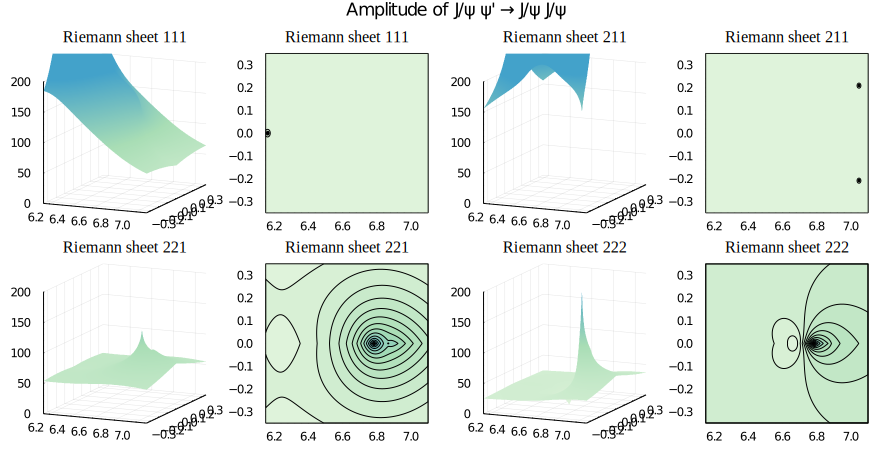

In [92]:
plt_tmatrix_3c(parametersets_3c[1,2:end], zup=200)

Fit 2:
* one virtual state pole on the 2nd sheet
* one pole above 7 GeV on the 2nd sheet (remote since this is above the $J/\psi \psi(3770)$ threshold)

In [92]:
polesdf_3c_fit2[14,:]

DataFrameRow
│ Row │ pole_rs111 │ pole_rs211_low       │ pole_rs211_high    │ pole_rs221 │ pole_rs222 │
│     │ Complex…   │ Complex{Float64}     │ Complex{Float64}   │ Complex…   │ Complex…   │
├─────┼────────────┼──────────────────────┼────────────────────┼────────────┼────────────┤
│ 14  │ NaN+NaN*im │ 6.19173-1.9691e-13im │ 7.06882+0.437775im │ NaN+NaN*im │ NaN+NaN*im │

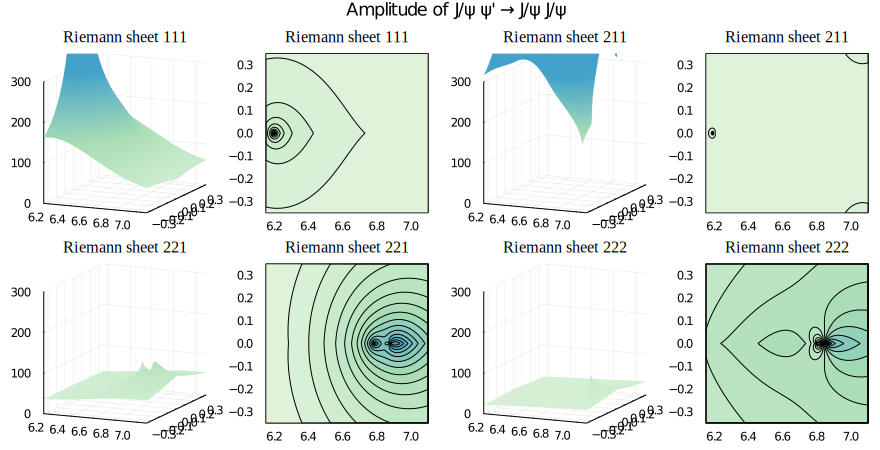

In [93]:
plt_tmatrix_3c(parametersets_3c_fit2[14, 2:end], zup=300)

* Poles on the 1st and 2nd Riemann sheets

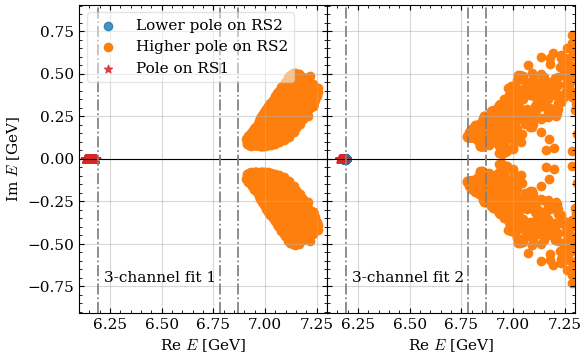

In [94]:
let pole1, pole211, pole211high, pole1_fit2, pole211_fit2, pole211high_fit2
    
    pole1 = polesdf_3c[(real.(polesdf_3c.pole_rs111)) .>0, 1]
    pole211 = polesdf_3c[isnan.(real.(polesdf_3c.pole_rs111)), 2]
    pole211high = polesdf_3c[real.(polesdf_3c.pole_rs211_high) .>0, 3]
    
    pole1_fit2 = polesdf_3c_fit2[(real.(polesdf_3c_fit2.pole_rs111)) .>0, 1]
    pole211_fit2 = polesdf_3c_fit2[isnan.(real.(polesdf_3c_fit2.pole_rs111)), 2]
    pole211high_fit2 = polesdf_3c_fit2[real.(polesdf_3c_fit2.pole_rs211_high) .>0, 3]

    fig, ax = PyPlot.subplots(1,2, figsize = (6.4, 4), sharey = "row")
    PyPlot.subplots_adjust(wspace = 0)
    
    ax[1].axhline([0], color=:k, lw=0.8)   
    ax[1].scatter(real.(pole211), imag.(pole211), color=:C0, label="Lower pole on RS2", alpha=0.8)
    ax[1].scatter(real.(pole211high), imag.(pole211high), color=:C1, label="Higher pole on RS2")
    ax[1].scatter(real.(pole211high), -imag.(pole211high), color=:C1)
    ax[1].scatter(real.(pole1), imag.(pole1), color=:C3, label="Pole on RS1", alpha=0.8, marker="*" )
    ax[1].axvline(2*mjψ, c = "gray", ls = "-.") # , label=L"2m_{J/\psi}"
    ax[1].axvline(mjψ+mψp, c = "gray", ls = "-.") 
    ax[1].axvline(mjψ+mψ3770, c = "gray", ls = "-.") 
    ax[1].set_xlabel("Re "*L"E"*" [GeV]"); ax[1].set_ylabel("Im "*L"E"*" [GeV]"); ax[1].set_xlim(6.1,7.3)
    ax[1].legend(framealpha = 0.5)
    ax[1].annotate("3-channel fit 1", xy = (0.1,0.1), xycoords = "axes fraction")
    
    ax[2].axhline([0], color=:k, lw=0.8)
    ax[2].scatter(real.(pole211_fit2), imag.(pole211_fit2), color=:C0, label="Lower pole on RS2", alpha=0.8)
    ax[2].scatter(real.(pole211high_fit2), imag.(pole211high_fit2), color=:C1, label="Higher pole on RS2")
    ax[2].scatter(real.(pole211high_fit2), -imag.(pole211high_fit2), color=:C1)
    ax[2].scatter(real.(pole1_fit2), imag.(pole1_fit2), color=:C3, label="Pole on RS1", alpha=0.8, marker="*" )
    ax[2].axvline(2*mjψ, c = "gray", ls = "-.") 
    ax[2].axvline(mjψ+mψp, c = "gray", ls = "-.") 
    ax[2].axvline(mjψ+mψ3770, c = "gray", ls = "-.") 
    ax[2].set_xlabel("Re "*L"E"*" [GeV]"); ax[2].set_xlim(6.1,7.3)
    ax[2].annotate("3-channel fit 2", xy = (0.1,0.1), xycoords = "axes fraction")
    nothing
end
# PyPlot.savefig("poles_3c.pdf")

In [95]:
function plt_best_band_3c(df::DataFrame, fitfun; withdata=true,
        xlab=L"M_{J/\psi\, J/\psi}"*" [GeV]", ylab="Events / (28 MeV)")
    
    df2 = parametersets_3c_fit2
    dist_extrema(w) = dist_minmax(df, fitfun, w)  
    dist_extrema2(w) = dist_minmax(df2, fitfun, w) 
    
    n = 500; 
    wv = withdata ? LinRange(6.194, 9.2, n) : LinRange(mjψ+mψp+0.000001, 9.2, n) 
    best = zeros(Float64, n); 
    best2 = zeros(Float64, n); 
    paras = Array(df[1, 2:end])
    paras2 = Array(df2[1, 2:end])
    @simd for i = 1:n
        @inbounds best[i] = fitfun(wv[i], paras)
        @inbounds best2[i] = fitfun(wv[i], paras2)
    end
    
    PyPlot.subplots(figsize=(6,4))
    yv = permutedims(reduce(hcat, dist_extrema.(wv))) 
    PyPlot.fill_between( wv,  yv[:,1], yv[:,2], alpha = 0.5, facecolor = "C1" )
    yv = permutedims(reduce(hcat, dist_extrema2.(wv))) 
    PyPlot.fill_between( wv,  yv[:,1], yv[:,2], alpha = 0.5, facecolor = :gray )
    
    if withdata 
        data = data_full;
        PyPlot.errorbar(data.x, data.y, data.err, c="b", fmt = "o", alpha=0.8, label="LHCb data" )
        PyPlot.plot(wv, best, "r-", lw=1.35, label = "3-channel fit-1")
        PyPlot.plot(wv, best2, "k--", lw=1.35, label = "3-channel fit-2")
        PyPlot.plot(wv, dpsmodel.(wv, Ref(args(dpsfit_poly))), label="DPS", ":" ) 
        PyPlot.axvline(mjψ+mψp, c = "gray", ls = "-.") # , label=L"m_{J/\psi} + m_{\psi(2S)}")
        PyPlot.axvline(mjψ+mψ3770, c = "gray", ls = "-.") #, label=L"m_{J/\psi} + m_{\psi(3770)}") 
        PyPlot.axvspan(2*mjψ, data.x[ndata]+0.01, color=:C2, alpha=0.2, label="Fit range")
        PyPlot.xlabel(xlab); PyPlot.ylabel(ylab)
        PyPlot.xlim(6.15, 9); PyPlot.ylim(0, 190); 
    else
        best2c = zeros(Float64, n); 
        df2c = parametersets_2c
        paras2c = Array(df2c[1, 2:end])
        @simd for i = 1:n
            @inbounds best2c[i] = dist_psipsip(wv[i], paras2c)
        end
        PyPlot.plot(wv, best2c, "b:", lw=1.35, label = "2-channel fit" )
        dist_extrema2c(w) = dist_minmax(df2c, dist_psipsip, w) 
        yv = permutedims(reduce(hcat, dist_extrema2c.(wv))) 
        PyPlot.fill_between( wv,  yv[:,1], yv[:,2], alpha = 0.35, facecolor = :blue )
        
        PyPlot.plot(wv, best, "r-", lw=1.35, label = "3-channel fit 1" )
        PyPlot.plot(wv, best2, "k--", lw=1.35, label = "3-channel fit 2" )
#         PyPlot.plot(wv, phsp.(wv,mjψ,mψp) .*2e4 , "-.", lw=1.35, label = "phase space" )
        PyPlot.xlabel(xlab); PyPlot.ylabel(ylab); 
        PyPlot.xlim(6.75, 7.2); PyPlot.ylim(0, 220); 
    end
    
    PyPlot.legend(framealpha = 0.5);
    nothing
end

plt_best_band_3c (generic function with 1 method)

In [96]:
# J/ψ ψ' distribution for three-channel model
function dist3_psipsip(w, par)
    if typeof(par) <: AbstractArray
        npar = length(par)
        t11, t21, t31 = @view tmatrix(w, view(par, 1:6))[1:3]
        t22, t32 = @view tmatrix(w, view(par, 1:6))[5:6]
        α, β, r1, r2, bg, ct = view(par, (npar-5):npar)
    elseif typeof(par) <: Tuple
        a11, a12, a13, a22, a23, a33, α, β, r1, r2, bg, ct = par
        t11, t21, t31, t12, t22, t32 = tmatrix(w, par)
    else
        error("typeof(par) = $(typeof(par)); it has to be either an Array or a Tuple.")
    end
    
    s = w^2
    g1 = Gdr(w, mjψ, mjψ)
    g2 = Gdr(w, mψp, mjψ)
    g3 = Gdr(w, mψ3770, mjψ)
    
    amp = α*exp(-β*s) * (ct + g1*t21 + r1*g2*t22 + r2*g3*t32) 
    
    return phsp(w,mjψ,mψp) * (abs2(amp) + bg)
end

dist3_psipsip (generic function with 1 method)

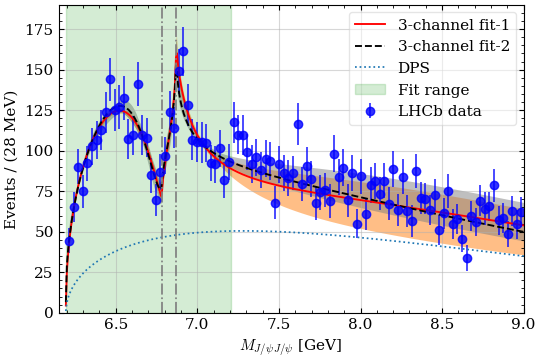

In [97]:
plt_best_band_3c(parametersets_3c, dist3)
# PyPlot.savefig("bestfit_3c.pdf")

* Prediction of the $J/\psi \psi(2S)$ invariant mass distribution

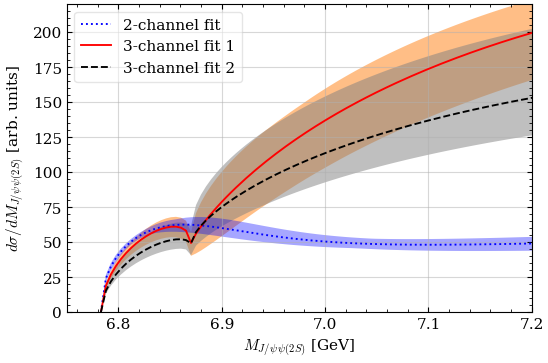

In [98]:
plt_best_band_3c(parametersets_3c, dist3_psipsip, withdata=false, 
    xlab=L"M_{J/\psi\, \psi(2S)}"*" [GeV]", ylab=L"d\sigma/dM_{J/\psi\, \psi(2S)}"*" [arb. units]")
# PyPlot.savefig("dist_psipsip.pdf")

## Predicting ERE parameters for double-$J/\psi$

In [99]:
tmatrix(7, args(fit_3c_best))

3×3 SArray{Tuple{3,3},Complex{Float64},2,9} with indices SOneTo(3)×SOneTo(3):
 -0.965959-46.0199im   51.4694-34.7509im   21.6938+38.7546im
   51.4694-34.7509im   33.7548-116.531im  -30.0904-37.1971im
   21.6938+38.7546im  -30.0904-37.1971im  -89.0812-91.2765im

Let us make a prediction on the ERE parameters for double $J/\psi$ scattering:

\begin{equation}
T(k) = - 8\pi \sqrt{s} \left[\frac1{a} + \frac12 r k^2 -i\, k + \mathcal{O}(k^4) \right]^{-1}.
\end{equation}

\begin{equation}
\frac1{a} + \frac12 r k^2 + \mathcal{O}(k^4) = -8\pi \sqrt{s}\,T^{-1}(k) + i\, k = -8\pi \sqrt{s}\,{\rm Re}\,T^{-1}(k).
\end{equation}

Thus, we have

\begin{equation}
    a = -\frac{T(k=0)}{8\pi (m_1+m_2)}, \qquad
    r = -\frac{8\pi}{\mu} \frac{d}{dE}\left[E\,{\rm Re}\,(T^{-1}) \right]_{E=m_1+m_2} 
     = -\frac{8\pi}{\mu} \left[{\rm Re}\,(T^{-1}) + (m_1+m_2) \frac{d}{dE}{\rm Re}\,(T^{-1})  \right]_{E=m_1+m_2} .
\end{equation}
with $E=\sqrt{s}$.

The scattering length $a$ and the effective range $r$ can be used to evaluate (estimate) the **compositeness** for an $S$-wave bound (virtual or resonance) state that is close to threshold, see our recent paper [2007.05329](https://arxiv.org/pdf/2007.05329.pdf):

\begin{equation}
  \bar X_A = \sqrt{\frac1{1+2|r/a|}}.
\end{equation}

In [97]:
# in units of fm
function scattering_length(pars; nchannels=2)
    tth = nchannels==2 ? T(2mjψ, pars)[1] : tmatrix(2mjψ, pars)[1]
    return -real(tth)/(16π*mjψ) * hbarc
end

# in units of fm
function effective_range(pars; nchannels=2)
    t(w) = nchannels==2 ? T(w, pars)[1] : tmatrix(w, pars)[1]
    eps = 1e-8; μ = mjψ/2; 
    th = 2mjψ +0.0000001 # this small number needs to be added to get stable derivative
    
    deriv = real(1/t(th)) + th * ( real(1/t(th + eps)) - real(1/t(th)) )/eps
    
    return - 8π/μ * deriv * hbarc
end

function compositeness(pars; nchannels=2)
    a = scattering_length(pars, nchannels=nchannels)
    r = effective_range(pars, nchannels=nchannels)
    return sqrt( 1.0/(1 + 2*abs(r/a)) )
end

compositeness (generic function with 1 method)

### scattering length

In [98]:
# 2-channel: the prediction is |a|>0.48 fm
let a = [scattering_length(p[2:end]) for p in eachrow(parametersets_2c)]
    a[1], extrema(a[a .<0]), extrema(a[a .>=0]) 
end

(0.8017970619013688, (-51.78214626564465, -0.48614052407058356), (0.4763030279472078, 35.89197185156458))

In [99]:
# 3-channel fit 1
let a = [scattering_length(p[2:end], nchannels=3) for p in eachrow(parametersets_3c)]
    a[1], extrema(a)
end

(-0.6087320418939616, (-0.9334287286843858, -0.4214432412710257))

In [100]:
# 3-channel fit 2
let a = [scattering_length(p[2:end], nchannels=3) for p in eachrow(parametersets_3c_fit2)]
    a[1], extrema(a[a .<0]), extrema(a[a .>=0]) 
end

(1.6306813167830991, (-1.7199886441149812, -0.5960199311250023), (0.9906449399172577, 3.062459457138077))

### effective range

In [101]:
let r = [effective_range(p[2:end]) for p in eachrow(parametersets_2c)]
    r[1], extrema(r)
end

(-2.176136117586465, (-2.981793061590345, -1.5193153954414813))

In [102]:
let r = [effective_range(p[2:end], nchannels=3) for p in eachrow(parametersets_3c)]
    r[1], extrema(r), extrema(r) .- r[1]
end

(-0.060100621863798505, (-0.10197134969244319, -0.028999048685882486), (-0.041870727828644684, 0.03110157317791602))

In [103]:
let r = [effective_range(p[2:end], nchannels=3) for p in eachrow(parametersets_3c_fit2)]
    r[1], extrema(r), extrema(r) .- r[1]
end

(-0.08890652987376983, (-0.1388474856926661, -0.00814273810380365), (-0.04994095581889628, 0.08076379176996618))

### compositeness

In [104]:
x_2c = let x = [compositeness(p[2:end]) for p in eachrow(parametersets_2c)]
    x[1], extrema(x), extrema(x) .- x[1]
end

(0.39441834237496914, (0.2719583986048139, 0.9705230408924357), (-0.12245994377015523, 0.5761046985174665))

In [105]:
x_3c = let x = [compositeness(p[2:end], nchannels=3) for p in eachrow(parametersets_3c)]
    x[1], extrema(x), extrema(x) .- x[1]
end

(0.913837951267695, (0.84489479949614, 0.9558592202241161), (-0.06894315177155497, 0.04202126895642111))

In [106]:
x_3c_fit2 = let x = [compositeness(p[2:end], nchannels=3) for p in eachrow(parametersets_3c_fit2)]
    x[1], extrema(x), extrema(x) .- x[1]
end

(0.9495677719194691, (0.8907490808195911, 0.9866118879748311), (-0.05881869109987792, 0.037044116055362064))

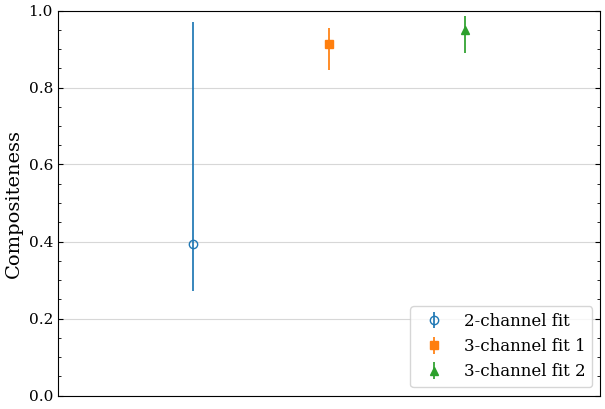

In [111]:
function plt_x()
    fig, ax = PyPlot.subplots(figsize=(7,5)) 
    ax.errorbar(1, x_2c[1], yerr=[[0.122], [0.576]], fmt="o", mfc=:none, label="2-channel fit")
    ax.errorbar(2, x_3c[1], yerr=[[0.069], [0.042]], fmt="s", label="3-channel fit 1")
    ax.errorbar(3, x_3c_fit2[1], yerr=[[0.059], [0.037]], fmt="^", label="3-channel fit 2")
    
    ax.set_xticks([]); ax.set_ylabel("Compositeness", fontsize=14)
    ax.legend(fontsize=12, loc="lower right"); ax.set_xlim(0,4); ax.set_ylim(0,1)
    ax.grid(axis="x")
end

plt_x()

## Residue

The residues of the amplitude $T_{ij}$ at pole $E_0$ is calculated via
\begin{equation}
{\rm Res}(T_{ij})=\lim_{E\to E_0} (E^2-E_0^2)T_{ij}(E)
\end{equation}

Run the codes of definitions of T first

### 2channel

In [12]:
polesdf_2c = read_file("data/poles_2c.csv", cols=(:pole_rs1, :pole_rs2_low, :pole_rs2_high, :pole_rs3))
parametersets_2c = DataFrame!(CSV.File("data/parametersets_2c.csv"))

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = read_file(::String; cols::NTuple{4,Symbol}) at In[11]:5
└ @ Main .\In[11]:5
┌ Warning: `setindex!(df::DataFrame, v::AbstractVector, col_ind::ColumnIndex)` is deprecated, use `begin
│     df[!, col_ind] = v
│     df
│ end` instead.
│   caller = read_file(::String; cols::NTuple{4,Symbol}) at In[11]:5
└ @ Main .\In[11]:5


322×11 DataFrame
│ Row │ chisq   │ a1         │ a2       │ c       │ b1       │ b2       │ alpha   │ beta     │ r       │ bg      │ ct      │
│     │ Float64 │ Float64    │ Float64  │ Float64 │ Float64  │ Float64  │ Float64 │ Float64  │ Float64 │ Float64 │ Float64 │
├─────┼─────────┼────────────┼──────────┼─────────┼──────────┼──────────┼─────────┼──────────┼─────────┼─────────┼─────────┤
│ 1   │ 28.7082 │ 0.193394   │ -4.18333 │ 2.94252 │ -1.75476 │ -7.10517 │ 69.853  │ 0.012336 │ 1.0     │ 0.0     │ 3.25253 │
│ 2   │ 29.708  │ -0.312697  │ -4.38354 │ 2.90513 │ -1.45395 │ -7.1714  │ 69.5201 │ 0.012336 │ 1.0     │ 0.0     │ 3.23946 │
│ 3   │ 29.7083 │ 0.77328    │ -3.93441 │ 3.03771 │ -2.17564 │ -6.99281 │ 68.4255 │ 0.012336 │ 1.0     │ 0.0     │ 3.36018 │
│ 4   │ 29.7082 │ 0.213797   │ -4.34914 │ 3.30079 │ -1.95072 │ -6.98948 │ 67.7341 │ 0.012336 │ 1.0     │ 0.0     │ 3.38281 │
│ 5   │ 29.7082 │ 0.685926   │ -3.86683 │ 3.09419 │ -2.24948 │ -6.96575 │ 66.3088 │ 0.012336 │ 1.0     │ 0.0     │ 3.47981 │
│ 6   │ 29.7082 │ 0.087097   │ -4.80733 │ 3.02958 │ -1.64165 │ -7.47872 │ 71.5544 │ 0.012336 │ 1.0     │ 0.0     │ 3.16193 │
│ 7   │ 29.1992 │ 0.103959   │ -4.31797 │ 3.0474  │ -1.7841  │ -6.71576 │ 68.9013 │ 0.012336 │ 1.0     │ 0.0     │ 3.30568 │
│ 8   │ 29.7078 │ 0.239563   │ -4.00992 │ 2.98822 │ -1.94928 │ -6.99061 │ 62.4349 │ 0.012336 │ 1.0     │ 0.0     │ 3.65598 │
│ 9   │ 29.7082 │ 0.120701   │ -4.38062 │ 2.87215 │ -1.54423 │ -7.21879 │ 77.9983 │ 0.012336 │ 1.0     │ 0.0     │ 2.88485 │
│ 10  │ 29.7083 │ 0.291844   │ -3.97951 │ 3.0095  │ -2.00357 │ -6.98136 │ 62.5221 │ 0.012336 │ 1.0     │ 0.0     │ 3.66061 │
⋮
│ 312 │ 29.7055 │ 0.171184   │ -4.13997 │ 3.09861 │ -1.95224 │ -6.71576 │ 63.7334 │ 0.012336 │ 1.0     │ 0.0     │ 3.59039 │
│ 313 │ 29.7082 │ 0.288871   │ -3.97877 │ 3.00774 │ -2.00067 │ -6.98046 │ 62.5147 │ 0.012336 │ 1.0     │ 0.0     │ 3.66061 │
│ 314 │ 29.7083 │ 0.226685   │ -4.29352 │ 3.05297 │ -1.93288 │ -7.16653 │ 63.171  │ 0.012336 │ 1.0     │ 0.0     │ 3.61617 │
│ 315 │ 29.708  │ 0.171059   │ -4.54983 │ 3.07204 │ -1.84492 │ -7.32271 │ 65.0056 │ 0.012336 │ 1.0     │ 0.0     │ 3.5057  │
│ 316 │ 29.7082 │ 0.123356   │ -4.73206 │ 3.06722 │ -1.74555 │ -7.43382 │ 67.8142 │ 0.012336 │ 1.0     │ 0.0     │ 3.34994 │
│ 317 │ 29.7078 │ 0.234715   │ -4.01394 │ 2.98732 │ -1.94446 │ -6.99217 │ 62.4349 │ 0.012336 │ 1.0     │ 0.0     │ 3.65535 │
│ 318 │ 29.7082 │ -0.0804348 │ -4.38047 │ 2.80839 │ -1.4632  │ -7.17422 │ 70.3414 │ 0.012336 │ 1.0     │ 0.0     │ 3.17173 │
│ 319 │ 29.7139 │ 0.13996    │ -4.36977 │ 2.8808  │ -1.56144 │ -7.21571 │ 78.0964 │ 0.012336 │ 1.0     │ 0.0     │ 2.88485 │
│ 320 │ 29.7082 │ 0.160347   │ -4.35681 │ 2.89066 │ -1.58127 │ -7.21161 │ 78.0964 │ 0.012336 │ 1.0     │ 0.0     │ 2.8888  │
│ 321 │ 29.7083 │ 0.529837   │ -3.98707 │ 3.07909 │ -2.08808 │ -7.04223 │ 70.3055 │ 0.012336 │ 1.0     │ 0.0     │ 3.28934 │
│ 322 │ 29.7082 │ 0.288111   │ -3.98036 │ 3.00803 │ -2.0002  │ -6.98128 │ 62.5132 │ 0.012336 │ 1.0     │ 0.0     │ 3.66061 │

In [83]:
res_df_2c= DataFrame(rs1=Real[], rs2_low=Real[], rs2_high=Real[], rs3=Real[]) 
for i=1:nrow(parametersets_2c)
    restem=Vector(undef,4)
    rss=(1,2,2,3)
    for j=1:4
        #different Riemann sheets
        w0=polesdf_2c[i,j]
        resfun(w)=sqrt(abs(T(w,parametersets_2c[i,2:6],rss[j])[1]*(w^2-w0^2)))
        res7=resfun(w0-10E-7)
        res8=resfun(w0-10E-8)
        #shows the residue and relative error between 10E-8 and 10E-7
        restem[j]= res8
    end
    push!(res_df_2c, restem)
end  

In [82]:
# res_df_2c= DataFrame(rs1=Tuple[], rs2_low=Tuple[], rs2_high=Tuple[], rs3=Tuple[]) 
# for i=1:nrow(parametersets_2c)
#     restem=Vector(undef,4)
#     rss=(1,2,2,3)
#     for j=1:4
#         #different Riemann sheets
#         w0=polesdf_2c[i,j]
#         resfun(w)=sqrt(abs(T(w,parametersets_2c[i,2:6],rss[j])[1]*(w^2-w0^2)))
#         res7=resfun(w0-10E-7)
#         res8=resfun(w0-10E-8)
#         #shows the residue and relative error between 10E-8 and 10E-7
#         restem[j]= (res8,abs((res8-res7)/res8))
#     end
#     push!(res_df_2c, restem)
# end  

In [84]:
@show res_df_2c;

res_df_2c = 322×4 DataFrame
│ Row │ rs1     │ rs2_low │ rs2_high │ rs3     │
│     │ Real    │ Real    │ Real     │ Real    │
├─────┼─────────┼─────────┼──────────┼─────────┤
│ 1   │ NaN     │ 11.3117 │ 20.8346  │ 11.7376 │
│ 2   │ NaN     │ 13.7149 │ 22.1942  │ 12.3376 │
│ 3   │ NaN     │ 10.33   │ 19.3959  │ 10.6241 │
│ 4   │ 7.8687  │ 13.9127 │ 19.944   │ 11.3023 │
│ 5   │ NaN     │ 10.7489 │ 19.1763  │ 10.0513 │
│ 6   │ NaN     │ 11.974  │ 21.2948  │ 13.1074 │
│ 7   │ 8.86601 │ 12.7615 │ 20.5637  │ 11.8528 │
│ 8   │ NaN     │ 11.6069 │ 20.1491  │ 10.5686 │
│ 9   │ NaN     │ 11.1856 │ 21.4902  │ 13.291  │
│ 10  │ NaN     │ 11.5389 │ 19.9636  │ 10.4047 │
│ 11  │ 8.95418 │ 11.6325 │ 19.7458  │ 11.7846 │
│ 12  │ NaN     │ 10.455  │ 19.464   │ 10.1735 │
│ 13  │ NaN     │ 10.8212 │ 20.0591  │ 10.2143 │
│ 14  │ NaN     │ 11.6028 │ 20.7657  │ 10.5935 │
│ 15  │ NaN     │ 12.34   │ 21.431   │ 11.124  │
│ 16  │ NaN     │ 13.7171 │ 22.194   │ 12.3373 │
│ 17  │ NaN     │ 12.2141 │ 22.3035  │ 12

In [250]:
lower = polesdf_2c[2];
higher = polesdf_2c[real.(polesdf_2c.pole_rs2_high) .>6.25, 3];
pole1 = polesdf_2c[(real.(polesdf_2c.pole_rs1)) .>0, 1];
pole3 = polesdf_2c[4];

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[250]:1
└ @ Core In[250]:1
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[250]:4
└ @ Core In[250]:4


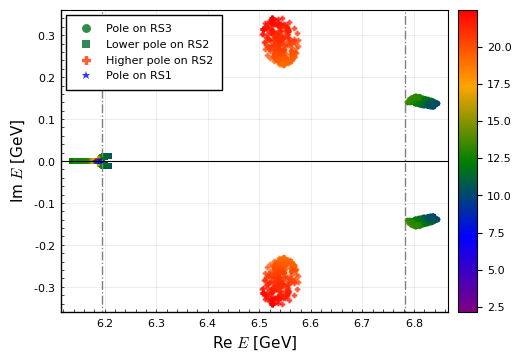

In [252]:
scatter(real.(pole3), imag.(pole3),zcolor=abs.(res_df_2c.rs3),m = (:circle,:rainbow, 0.8, Plots.stroke(0, :green)), label="Pole on RS3")
scatter!(real.(pole3), -imag.(pole3),zcolor=abs.(res_df_2c.rs3),m = (:circle,:rainbow, 0.8,Plots.stroke(0, :green)),label=false  )
scatter!(real.(lower), imag.(lower), zcolor=abs.(res_df_2c.rs2_low),m = (:rect,:rainbow, 0.8,Plots.stroke(0, :green)), label="Lower pole on RS2", alpha=0.8 )
scatter!(real.(lower), -imag.(lower),zcolor=abs.(res_df_2c.rs2_low),m = (:rect,:rainbow, 0.8,Plots.stroke(0, :green)),  alpha=0.8,label=false  )
scatter!(real.(higher), imag.(higher), zcolor=abs.(res_df_2c[real.(polesdf_2c.pole_rs2_high) .>6.25,3]),m = (:cross,:rainbow, 0.8,Plots.stroke(0, :green)), label="Higher pole on RS2"  )   
scatter!(real.(higher), -imag.(higher), zcolor=abs.(res_df_2c[real.(polesdf_2c.pole_rs2_high) .>6.25,3]),m = (:cross,:rainbow, 0.8,Plots.stroke(0, :green)),label=false )
scatter!(real.(pole1), imag.(pole1), zcolor=abs.(res_df_2c[res_df_2c.rs1.>0,1]),m = (:star5,:rainbow, 0.8,Plots.stroke(0, :green)), label="Pole on RS1", alpha=0.8, marker="*" )
hline!([0], color=:black, lw=0.8,label=false)
vline!([2*mjψ,mjψ+mψp], c = "gray",linestyle=:dashdot,label=false)
xlabel!("Re "*L"E"*" [GeV]"); ylabel!("Im "*L"E"*" [GeV]")
savefig("poles_residue.pdf")

### 3-channel

In [147]:
parametersets_3c = DataFrame!(CSV.File("data/parametersets_3c.csv"))
parametersets_3c_fit2 = DataFrame!(CSV.File("data/parametersets_3c_fit2.csv"))

polesdf_3c = read_file("data/poles_3c.csv", cols=(:pole_rs111, :pole_rs211_low, :pole_rs211_high, :pole_rs221, :pole_rs222))
polesdf_3c_fit2 = read_file("data/poles_3c_fit2.csv", cols=(:pole_rs111, :pole_rs211_low, :pole_rs211_high, :pole_rs221, :pole_rs222))

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = read_file(::String; cols::NTuple{5,Symbol}) at In[11]:5
└ @ Main .\In[11]:5
┌ Warning: `setindex!(df::DataFrame, v::AbstractVector, col_ind::ColumnIndex)` is deprecated, use `begin
│     df[!, col_ind] = v
│     df
│ end` instead.
│   caller = read_file(::String; cols::NTuple{5,Symbol}) at In[11]:5
└ @ Main .\In[11]:5


1045×5 DataFrame
│ Row  │ pole_rs111 │ pole_rs211_low        │ pole_rs211_high     │ pole_rs221 │ pole_rs222 │
│      │ Complex…   │ Complex{Float64}      │ Complex{Float64}    │ Complex…   │ Complex…   │
├──────┼────────────┼───────────────────────┼─────────────────────┼────────────┼────────────┤
│ 1    │ NaN+NaN*im │ 6.1888-1.40786e-11im  │ 6.89562+0.17936im   │ NaN+NaN*im │ NaN+NaN*im │
│ 2    │ NaN+NaN*im │ 6.1902+8.46756e-12im  │ 6.85912+0.250782im  │ NaN+NaN*im │ NaN+NaN*im │
│ 3    │ NaN+NaN*im │ 6.19061-6.09632e-11im │ 6.97439+0.41686im   │ NaN+NaN*im │ NaN+NaN*im │
│ 4    │ NaN+NaN*im │ 6.19144-6.7952e-15im  │ 6.87903+0.162829im  │ NaN+NaN*im │ NaN+NaN*im │
│ 5    │ NaN+NaN*im │ 6.19178-3.05799e-13im │ 7.02165+0.371869im  │ NaN+NaN*im │ NaN+NaN*im │
│ 6    │ NaN+NaN*im │ 6.19023+9.37519e-12im │ 7.02474+0.492434im  │ NaN+NaN*im │ NaN+NaN*im │
│ 7    │ NaN+NaN*im │ 6.18259+3.20723e-13im │ 6.93368-0.0318062im │ NaN+NaN*im │ NaN+NaN*im │
│ 8    │ NaN+NaN*im │ 6.19002+3.44716e-12im │ 6.77912+0.13582im   │ NaN+NaN*im │ NaN+NaN*im │
│ 9    │ NaN+NaN*im │ 6.19035-7.63909e-13im │ 6.79655+0.174466im  │ NaN+NaN*im │ NaN+NaN*im │
│ 10   │ NaN+NaN*im │ 6.19028+5.44298e-12im │ 6.85907+0.251284im  │ NaN+NaN*im │ NaN+NaN*im │
⋮
│ 1035 │ NaN+NaN*im │ 6.19147-1.05589e-14im │ 6.91356+0.233248im  │ NaN+NaN*im │ NaN+NaN*im │
│ 1036 │ NaN+NaN*im │ 6.18775+1.40771e-16im │ 7.09333+0.210914im  │ NaN+NaN*im │ NaN+NaN*im │
│ 1037 │ NaN+NaN*im │ 6.18574-1.34275e-14im │ 6.83253+0.146344im  │ NaN+NaN*im │ NaN+NaN*im │
│ 1038 │ NaN+NaN*im │ 6.18462-7.79808e-14im │ 6.85247+0.142227im  │ NaN+NaN*im │ NaN+NaN*im │
│ 1039 │ NaN+NaN*im │ 6.1832-9.70491e-14im  │ 7.4239-0.083601im   │ NaN+NaN*im │ NaN+NaN*im │
│ 1040 │ NaN+NaN*im │ 6.18463-7.52881e-14im │ 6.84419+0.14165im   │ NaN+NaN*im │ NaN+NaN*im │
│ 1041 │ NaN+NaN*im │ 6.1888-1.40786e-11im  │ 6.89562+0.17936im   │ NaN+NaN*im │ NaN+NaN*im │
│ 1042 │ NaN+NaN*im │ 6.18749+1.28125e-16im │ 7.30138+0.501965im  │ NaN+NaN*im │ NaN+NaN*im │
│ 1043 │ NaN+NaN*im │ 6.19076-7.10896e-11im │ 6.96885+0.317694im  │ NaN+NaN*im │ NaN+NaN*im │
│ 1044 │ NaN+NaN*im │ 6.18666-1.66692e-15im │ 7.37796+0.661505im  │ NaN+NaN*im │ NaN+NaN*im │
│ 1045 │ NaN+NaN*im │ 6.19144-8.24432e-15im │ 6.98544+0.389165im  │ NaN+NaN*im │ NaN+NaN*im │

In [163]:
# res_df_3c= DataFrame(rs111=Tuple[], rs211_low=Tuple[], rs211_high=Tuple[], rs221=Tuple[],rs222=Tuple[]) 
# res_df_3c_fit2= DataFrame(rs111=Tuple[], rs211_low=Tuple[], rs211_high=Tuple[], rs221=Tuple[],rs222=Tuple[])
# for i=1:nrow(parametersets_3c)
#     restem=Vector(undef,5)
#     rss=(111,211,211,221,222)
#     for j=1:5
#         #different Riemann sheets
#         w0=polesdf_3c[i,j]
#         resfun(w)=sqrt(abs(tmatrix(w,parametersets_3c[i,2:7];rs=rss[j])[1]*(w^2-w0^2)))
#         res7=resfun(w0-10E-7)
#         res8=resfun(w0-10E-8)
#         #shows the residue and relative error between 10E-8 and 10E-7
#         restem[j]= (res8,abs((res8-res7)/res8))
#     end
#     push!(res_df_3c, restem)
# end  

# for i=1:nrow(parametersets_3c_fit2)
#     restem=Vector(undef,5)
#     rss=(111,211,211,221,222)
#     for j=1:5
#         #different Riemann sheets
#         w0=polesdf_3c_fit2[i,j]
#         resfun(w)=sqrt(abs(tmatrix(w,parametersets_3c_fit2[i,2:7];rs=rss[j])[1]*(w^2-w0^2)))
#         res7=resfun(w0-10E-7)
#         res8=resfun(w0-10E-8)
#         #shows the residue and relative error between 10E-8 and 10E-7
#         restem[j]= (res8,abs((res8-res7)/res8))
#     end
#     push!(res_df_3c_fit2, restem)
# end 

In [149]:
@show res_df_3c;

res_df_3c = 1528×5 DataFrame
│ Row  │ rs111   │ rs211_low │ rs211_high │ rs221 │ rs222 │
│      │ Real    │ Real      │ Real       │ Real  │ Real  │
├──────┼─────────┼───────────┼────────────┼───────┼───────┤
│ 1    │ 18.873  │ NaN       │ 31.3301    │ NaN   │ NaN   │
│ 2    │ 20.3749 │ NaN       │ 33.6881    │ NaN   │ NaN   │
│ 3    │ 18.3722 │ NaN       │ 26.2366    │ NaN   │ NaN   │
│ 4    │ 20.6344 │ NaN       │ 35.8125    │ NaN   │ NaN   │
│ 5    │ 18.1192 │ NaN       │ 24.1653    │ NaN   │ NaN   │
│ 6    │ 22.1754 │ NaN       │ 33.8556    │ NaN   │ NaN   │
│ 7    │ 15.9169 │ NaN       │ 29.9899    │ NaN   │ NaN   │
│ 8    │ 21.8243 │ NaN       │ 34.6869    │ NaN   │ NaN   │
│ 9    │ 17.4916 │ NaN       │ 25.1045    │ NaN   │ NaN   │
│ 10   │ 21.8554 │ NaN       │ 34.0378    │ NaN   │ NaN   │
│ 11   │ 15.7535 │ NaN       │ 30.2829    │ NaN   │ NaN   │
│ 12   │ 15.4564 │ NaN       │ 32.9895    │ NaN   │ NaN   │
│ 13   │ 22.3007 │ NaN       │ 32.494     │ NaN   │ NaN   │
│ 14   │ 20

In [181]:
@show res_df_3c_fit2;

res_df_3c_fit2 = 1045×5 DataFrame
│ Row  │ rs111                  │ rs211_low              │ rs211_high             │ rs221      │ rs222      │
│      │ Tuple                  │ Tuple                  │ Tuple                  │ Tuple      │ Tuple      │
├──────┼────────────────────────┼────────────────────────┼────────────────────────┼────────────┼────────────┤
│ 1    │ (NaN, NaN)             │ (12.8051, 0.000200272) │ (30.7145, 1.56962e-6)  │ (NaN, NaN) │ (NaN, NaN) │
│ 2    │ (NaN, NaN)             │ (11.7566, 4.38321e-5)  │ (30.2026, 4.58884e-7)  │ (NaN, NaN) │ (NaN, NaN) │
│ 3    │ (NaN, NaN)             │ (11.4674, 4.63366e-5)  │ (39.6261, 1.47694e-5)  │ (NaN, NaN) │ (NaN, NaN) │
│ 4    │ (NaN, NaN)             │ (10.4862, 4.93441e-5)  │ (27.0932, 1.71454e-6)  │ (NaN, NaN) │ (NaN, NaN) │
│ 5    │ (NaN, NaN)             │ (10.1368, 6.61718e-5)  │ (40.1925, 2.31965e-7)  │ (NaN, NaN) │ (NaN, NaN) │
│ 6    │ (NaN, NaN)             │ (11.8444, 5.9107e-5)   │ (42.9852, 1.30845e-7)  │ (N

In [148]:
res_df_3c= DataFrame(rs111=Real[], rs211_low=Real[], rs211_high=Real[], rs221=Real[],rs222=Real[]) 
res_df_3c_fit2= DataFrame(rs111=Real[], rs211_low=Real[], rs211_high=Real[], rs221=Real[],rs222=Real[])
for i=1:nrow(parametersets_3c)
    restem=Vector(undef,5)
    rss=(111,211,211,221,222)
    for j=1:5
        #different Riemann sheets
        w0=polesdf_3c[i,j]
        resfun(w)=sqrt(abs(tmatrix(w,parametersets_3c[i,2:7];rs=rss[j])[1]*(w^2-w0^2)))
        res7=resfun(w0-10E-7)
        res8=resfun(w0-10E-8)
        #shows the residue and relative error between 10E-8 and 10E-7
        restem[j]= res8
    end
    push!(res_df_3c, restem)
end  

for i=1:nrow(parametersets_3c_fit2)
    restem=Vector(undef,5)
    rss=(111,211,211,221,222)
    for j=1:5
        #different Riemann sheets
        w0=polesdf_3c_fit2[i,j]
        resfun(w)=sqrt(abs(tmatrix(w,parametersets_3c_fit2[i,2:7];rs=rss[j])[1]*(w^2-w0^2)))
        res7=resfun(w0-10E-7)
        res8=resfun(w0-10E-8)
        #shows the residue and relative error between 10E-8 and 10E-7
        restem[j]= res8
    end
    push!(res_df_3c_fit2, restem)
end 

In [231]:
pole1 = polesdf_3c[(real.(polesdf_3c.pole_rs111)) .>0, 1]
    pole211 = polesdf_3c[real.(polesdf_3c.pole_rs211_low).>0, 2]
    pole211high = polesdf_3c[real.(polesdf_3c.pole_rs211_high) .>0, 3]
    
    pole1_fit2 = polesdf_3c_fit2[(real.(polesdf_3c_fit2.pole_rs111)) .>0, 1]
    pole211_fit2 = polesdf_3c_fit2[real.(polesdf_3c_fit2.pole_rs211_low).>0, 2]
    pole211high_fit2 = polesdf_3c_fit2[real.(polesdf_3c_fit2.pole_rs211_high) .>0, 3]
    
    res1 = res_df_3c[(real.(polesdf_3c.pole_rs111)) .>0, 1]
    res211 = res_df_3c[real.(polesdf_3c.pole_rs211_low).>0, 2]
    res211high =res_df_3c[real.(polesdf_3c.pole_rs211_high) .>0, 3]
    
    res1_fit2 = res_df_3c_fit2[(real.(polesdf_3c_fit2.pole_rs111)) .>0, 1]
    res211_fit2 =res_df_3c_fit2[real.(polesdf_3c_fit2.pole_rs211_low).>0, 2]
    res211high_fit2 =res_df_3c_fit2[real.(polesdf_3c_fit2.pole_rs211_high) .>0, 3];

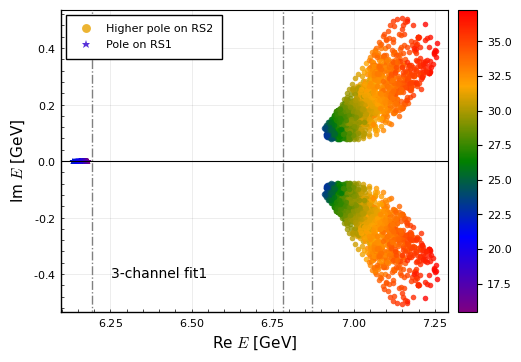

In [232]:
# scatter(real.(pole211), imag.(pole211),zcolor=res211,m = (:circle,:rainbow, 0.8, Plots.stroke(0, :green)), label="Lower pole on RS2", alpha=0.8)
scatter(real.(pole211high), imag.(pole211high), zcolor=res211high,m = (:circle,:rainbow, 0.8,Plots.stroke(0, :green)),label="Higher pole on RS2", alpha=0.8  )
scatter!(real.(pole211high), -imag.(pole211high), zcolor=res211high,m = (:circle,:rainbow, 0.8,Plots.stroke(0, :green)), label=false, alpha=0.8 )
scatter!(real.(pole1), imag.(pole1),zcolor=res1,m = (:star5,:rainbow, 0.8,Plots.stroke(0, :green)),  alpha=0.8,label="Pole on RS1"  )
hline!([0], color=:black, lw=0.8,label=false)
vline!([2*mjψ,mjψ+mψp,mjψ+mψ3770], c = "gray",linestyle=:dashdot,label=false)
xlabel!("Re "*L"E"*" [GeV]"); ylabel!("Im "*L"E"*" [GeV]")
annotate!([(6.4,-0.4,Plots.text("3-channel fit1",10))])
savefig("poles_residue_3c.pdf")

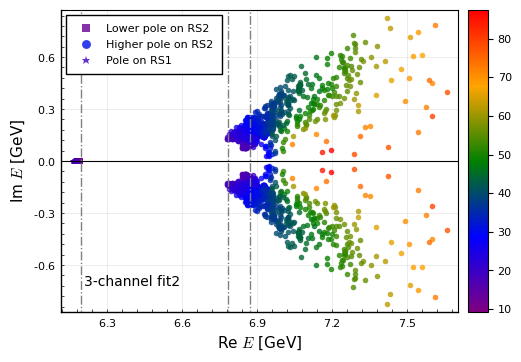

In [248]:
scatter(real.(pole211_fit2), imag.(pole211_fit2),zcolor=res211_fit2,m = (:rect,:rainbow, 0.8, Plots.stroke(0, :green)), label="Lower pole on RS2", alpha=0.8)
scatter!(real.(pole211high_fit2), imag.(pole211high_fit2), zcolor=res211high_fit2,m = (:circle,:rainbow, 0.8,Plots.stroke(0, :green)), label="Higher pole on RS2", alpha=0.8 )
scatter!(real.(pole211high_fit2), -imag.(pole211high_fit2), zcolor=res211high_fit2,m = (:circle,:rainbow, 0.8,Plots.stroke(0, :green)), label=false, alpha=0.8 )
scatter!(real.(pole1_fit2), imag.(pole1_fit2),zcolor=res1_fit2,m = (:star5,:rainbow, 0.8,Plots.stroke(0, :green)),  alpha=0.8,label="Pole on RS1"  )
hline!([0], color=:black, lw=0.8,label=false)
vline!([2*mjψ,mjψ+mψp,mjψ+mψ3770], c = "gray",linestyle=:dashdot,label=false)
xlabel!("Re "*L"E"*" [GeV]"); ylabel!("Im "*L"E"*" [GeV]")
annotate!([(6.4,-0.7,Plots.text("3-channel fit2",10))])
savefig("poles_residue_3c_fit2.pdf")